# [1.4.2] Function Vectors & Model Steering (exercises)

> **ARENA [Streamlit Page](https://arena-chapter1-transformer-interp.streamlit.app/22_📚_[1.4.2]_Function_Vectors_&_Model_Steering)**
>
> **Colab: [exercises](https://colab.research.google.com/github/callummcdougall/ARENA_3.0/blob/main/chapter1_transformer_interp/exercises/part42_function_vectors_and_model_steering/1.4.2_Function_Vectors_&_Model_Steering_exercises.ipynb?t=20250206) | [solutions](https://colab.research.google.com/github/callummcdougall/ARENA_3.0/blob/main/chapter1_transformer_interp/exercises/part42_function_vectors_and_model_steering/1.4.2_Function_Vectors_&_Model_Steering_solutions.ipynb?t=20250206)**

Please send any problems / bugs on the `#errata` channel in the [Slack group](https://join.slack.com/t/arena-uk/shared_invite/zt-2zick19fl-6GY1yoGaoUozyM3wObwmnQ), and ask any questions on the dedicated channels for this chapter of material.

You can collapse each section so only the headers are visible, by clicking the arrow symbol on the left hand side of the markdown header cells.

Links to all other chapters: [(0) Fundamentals](https://arena-chapter0-fundamentals.streamlit.app/), [(1) Transformer Interpretability](https://arena-chapter1-transformer-interp.streamlit.app/), [(2) RL](https://arena-chapter2-rl.streamlit.app/).

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/headers/header-14-2.png" width="350">

# Introduction

These exercises serve as an exploration of the following question: ***can we steer a model to produce different outputs / have a different behaviour, by intervening on the model's forward pass using vectors found by non gradient descent-based methods?***

The majority of the exercises focus on [function vectors](https://functions.baulab.info/): vectors which are extracted from forward passes on in-context learning (ICL) tasks, and added to the residual stream in order to trigger the execution of this task from a zero-shot prompt. The diagram below illustrates this.

<img src="https://functions.baulab.info/images/Paper/fv-demonstrations.png" width="650">

The exercises also take you through use of the `nnsight` library, which is designed to support this kind of work (and other interpretability research) on very large language models - i.e. larger than models like GPT2-Small which you might be used to at this point in the course.

The final set of exercises look at Alex Turner et al's work on [steering vectors](https://www.lesswrong.com/posts/5spBue2z2tw4JuDCx/steering-gpt-2-xl-by-adding-an-activation-vector), which is conceptually related but has different aims and methodologies.

## Content & Learning Objectives

### 1️⃣ Introduction to `nnsight`

In this section, you'll learn the basics of how to use the `nnsight` library: running forward passes on your model, and saving the internal states. You'll also learn some basics of HuggingFace models which translate over into `nnsight` models (e.g. tokenization, and how to work with model output).

> ##### Learning Objectives
>
> * Learn the basics of the `nnsight` library, and what it can be useful for
> * Learn some basics of HuggingFace models (e.g. tokenization, model output)
> * Use it to extract & visualise GPT-J-6B's internal activations

### 2️⃣ Task-encoding hidden states

We'll begin with the following question, posed by the Function Vectors paper:

> *When a transformer processes an ICL (in-context-learning) prompt with exemplars demonstrating task $T$, do any hidden states encode the task itself?*

We'll prove that the answer is yes, by constructing a vector $h$ from a set of ICL prompts for the **antonym task**, and intervening with our vector to make our model produce antonyms on zero-shot prompts.

This will require you to learn how to perform causal interventions with `nnsight`, not just save activations.

(Note - this section structurally follows section 2.1 of the function vectors paper).

> ##### Learning Objectives
>
> * Understand how `nnsight` can be used to perform causal interventions, and perform some yourself
> * Reproduce the "h-vector results" from the function vectors paper; that the residual stream does contain a vector which encodes the task and can induce task behaviour on zero-shot prompts


### 3️⃣ Function Vectors

In this section, we'll replicate the crux of the paper's results, by identifying a set of attention heads whose outputs have a large effect on the model's ICL performance, and showing we can patch with these vectors to induce task-solving behaviour on randomly shuffled prompts.

We'll also learn how to use `nnsight` for multi-token generation, and steer the model's behaviour. There exist exercises where you can try this out for different tasks, e.g. the Country-Capitals task, where you'll be able to steer the model to complete prompts like `"When you think of Netherlands, you usually think of"` by talking about Amsterdam.

(Note - this section structurally follows sections 2.2, 2.3 and some of section 3 from the function vectors paper).

> ##### Learning Objectives
>
> * Define a metric to measure the causal effect of each attention head on the correct performance of the in-context learning task
> * Understand how to rearrange activations in a model during an `nnsight` forward pass, to extract activations corresponding to a particular attention head
> * Learn how to use `nnsight` for multi-token generation

### 4️⃣ Steering Vectors in GPT2-XL

Here, we discuss a different but related set of research: Alex Turner's work on steering vectors. This also falls under the umbrella of "interventions in the residual stream using vectors found with forward pass (non-SGD) based methods in order to alter behaviour", but it has a different setup, objectives, and approach.

> ##### Learning Objectives
>
> * Understand the goals & main results from Alex Turner et al's work on steering vectors
> * Reproduce the changes in behaviour described in their initial post

### ☆ Bonus

Lastly, we discuss some possible extensions of function vectors & steering vectors work, which is currently an exciting area of development (e.g. with a paper on steering Llama 2-13b coming out as recently as December 2023).

## Setup code

In [25]:
import os
import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"
branch = "main"

# Install dependencies
try:
    import nnsight
except:
    %pip install openai>=1.56.2 nnsight einops jaxtyping plotly transformer_lens==2.11.0 git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python gradio typing-extensions
    %pip install --upgrade pydantic
    %pip install --force-reinstall circuitsvis numpy fsspec fastai
    # %pip install fsspec==2025.3.0



# Get root directory, handling 3 different cases: (1) Colab, (2) notebook not in ARENA repo, (3) notebook in ARENA repo
root = (
    "/content"
    if IN_COLAB
    else "/root"
    if repo not in os.getcwd()
    else str(next(p for p in Path.cwd().parents if p.name == repo))
)

if Path(root).exists() and not Path(f"{root}/{chapter}").exists():
    if not IN_COLAB:
        !sudo apt-get install unzip
        %pip install jupyter ipython --upgrade

    if not os.path.exists(f"{root}/{chapter}"):
        !wget -P {root} https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/{branch}.zip
        !unzip {root}/{branch}.zip '{repo}-{branch}/{chapter}/exercises/*' -d {root}
        !mv {root}/{repo}-{branch}/{chapter} {root}/{chapter}
        !rm {root}/{branch}.zip
        !rmdir {root}/{repo}-{branch}


if f"{root}/{chapter}/exercises" not in sys.path:
    sys.path.append(f"{root}/{chapter}/exercises")

os.chdir(f"{root}/{chapter}/exercises")

In [26]:
# %pip install fsspec==2025.3.0 torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 numpy==2.0
# %pip install --force-reinstall numpy
# %pip install --force-reinstall fastai

In [27]:
import logging
import os
import sys
import time
from collections import defaultdict
from pathlib import Path
import circuitsvis as cv
import einops
import numpy as np
import torch as t
from IPython.display import display
from jaxtyping import Float
from nnsight import CONFIG, LanguageModel
from openai import OpenAI
from rich import print as rprint
from rich.table import Table
from torch import Tensor

# Hide some info logging messages from nnsight
logging.disable(sys.maxsize)

t.set_grad_enabled(False)
device = t.device("mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu")

# Make sure exercises are in the path
chapter = "chapter1_transformer_interp"
section = "part42_function_vectors_and_model_steering"
root_dir = next(p for p in Path.cwd().parents if (p / chapter).exists())
exercises_dir = root_dir / chapter / "exercises"
section_dir = exercises_dir / section

import part42_function_vectors_and_model_steering.solutions as solutions
import part42_function_vectors_and_model_steering.tests as tests
from plotly_utils import imshow

MAIN = __name__ == "__main__"

# 1️⃣ Introduction to `nnsight`

> ##### Learning Objectives
>
> * Learn the basics of the `nnsight` library, and what it can be useful for
> * Learn some basics of HuggingFace models (e.g. tokenization, model output)
> * Use it to extract & visualise GPT-J-6B's internal activations

## Remote execution

We'll start by discussing [remote execution]((https://nnsight.net/notebooks/features/remote_execution/)) - the ability `nnsight` has to run models on an external server, which is one of the major benefits of the library as a research tool. This helps you bypass the memory & computational limits you might be faced with on your own machine. For remote execution to work, you need 2 things:

1. An API key fromm the community Discord, which you can request [here](https://login.ndif.us/)
2. The model you're working with being live - you can see all live models in the status page [here](https://nnsight.net/status/)

Note that the status page sometimes takes ~5 minutes to load all live models - click the dropdown below to see an example of what the status page should look like once the models have loaded. If you can't see the model you're looking for in this list, then you should set `REMOTE=False` for these exercises, or else make a request to the NDIF Discord to get the model live.

<details>
<summary>Example status page</summary>

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/ndif-status.png" width="650">

</details>

## Important syntax

Here, we'll discuss some important syntax for interacting with `nnsight` models. Since these models are extensions of HuggingFace models, some of this information (e.g. tokenization) applies to plain HuggingFace models as well as `nnsight` models, and some of it (e.g. forward passes) is specific to `nnsight`, i.e. it would work differently if you just had a standard HuggingFace model. Make sure to keep this distinction in mind, otherwise syntax can get confusing!

### Model config

Each model comes with a `model.config`, which contains lots of useful information about the model (e.g. number of heads and layers, size of hidden layers, etc.). You can access this with `model.config`. Run the code below to see this in action, and to define some useful variables for later.

In [28]:
model = LanguageModel("EleutherAI/gpt-j-6b", device_map="auto", torch_dtype=t.bfloat16)
tokenizer = model.tokenizer

N_HEADS = model.config.n_head
N_LAYERS = model.config.n_layer
D_MODEL = model.config.n_embd
D_HEAD = D_MODEL // N_HEADS

print(f"Number of heads: {N_HEADS}")
print(f"Number of layers: {N_LAYERS}")
print(f"Model dimension: {D_MODEL}")
print(f"Head dimension: {D_HEAD}\n")

print("Entire config: ", model.config)

Number of heads: 16
Number of layers: 28
Model dimension: 4096
Head dimension: 256

Entire config:  GPTJConfig {
  "activation_function": "gelu_new",
  "architectures": [
    "GPTJForCausalLM"
  ],
  "attn_pdrop": 0.0,
  "bos_token_id": 50256,
  "embd_pdrop": 0.0,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gptj",
  "n_embd": 4096,
  "n_head": 16,
  "n_inner": null,
  "n_layer": 28,
  "n_positions": 2048,
  "resid_pdrop": 0.0,
  "rotary": true,
  "rotary_dim": 64,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50,
      "temperature": 1.0
    }
  },
  "tie_word_embeddings": false,
  "tokenizer_class": "GPT2Tokenizer",
  "torch_dtype": "bfloat16",
  "transformers_

### Tokenizers

A model comes with a tokenizer, accessable with `model.tokenizer` (just like TransformerLens). Unlike TransformerLens, we won't be using utility functions like `model.to_str_tokens`, instead we'll be using the tokenizer directly. Some important functions for today's exercises are:

* `tokenizer` (i.e. just calling it on some input)
    * This takes in a string (or list of strings) and returns the tokenized version.
    * It will return a dictionary, always containing `input_ids` (i.e. the actual tokens) but also other things which are specific to the transformer model (e.g. `attention_mask` - see dropdown).
    * Other useful arguments for this function:
        * `return_tensors` - if this is `"pt"`, you'll get results returned as PyTorch tensors, rather than lists (which is the default).
        * `padding` - if True (default is False), the tokenizer can accept sequences of variable length. The shorter sequences get padded at the beginning (see dropdown below for more).
* `tokenizer.decode`
    * This takes in tokens, and returns the decoded string.
    * If the input is an integer, it returns the corresponding string. If the input is a list / 1D array of integers, it returns all those strings concatenated (which can sometimes not be what you want).
* `tokenizer.batch_decode`
    * Equivalent to `tokenizer.decode`, but it doesn't concatenate.
    * If the input is a list / 1D integer array, it returns a list of strings. If the input is 2D, it will concatenate within each list.
* `tokenizer.tokenize`
    * Takes in a string, and returns a list of strings.

Run the code below to see some examples of these functions in action.

In [29]:
# Calling tokenizer returns a dictionary, containing input ids & other data.
# If returned as a tensor, then by default it will have a batch dimension.
print(tokenizer("This must be Thursday", return_tensors="pt"))

# Decoding a list of integers, into a concatenated string.
print(tokenizer.decode([40, 1239, 714, 651, 262, 8181, 286, 48971, 12545, 13]))

# Using batch decode, on both 1D and 2D input.
print(tokenizer.batch_decode([4711, 2456, 481, 307, 6626, 510]))
print(tokenizer.batch_decode([[1212, 6827, 481, 307, 1978], [2396, 481, 428, 530]]))

# Split sentence into tokens (note we see the special Ġ character in place of prepended spaces).
print(tokenizer.tokenize("This sentence will be tokenized"))

{'input_ids': tensor([[1212, 1276,  307, 3635]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
I never could get the hang of Thursdays.
['These', ' words', ' will', ' be', ' split', ' up']
['This sentence will be together', 'So will this one']
['This', 'Ġsentence', 'Ġwill', 'Ġbe', 'Ġtoken', 'ized']


<details>
<summary>Note on <code>attention_mask</code> (optional)</summary>

`attention_mask`, which is a series of 1s and 0s. We mask attention at all 0-positions (i.e. we don't allow these tokens to be attended to). This is useful when you have to do padding. For example:

```python
model.tokenizer(["Hello world", "Hello"], return_tensors="pt", padding=True)
```

will return:

```python
{
    'attention_mask': tensor([[1, 1], [0, 1]]),
    'input_ids': tensor([[15496,   995], [50256, 15496]])
}
```

We can see how the shorter sequence has been padded at the beginning, and attention to this token will be masked.

</details>

### Model outputs

At a high level, there are 2 ways to run our model: using the `trace` method (a single forward pass) and the `generate` method (generating multiple tokens). We'll focus on `trace` for now, and we'll discuss `generate` when it comes to multi-token generation later.

The default behaviour of forward passes in normal HuggingFace models is to return an object containing logits (and optionally a bunch of other things). The default behaviour of `trace` in `nnsight` is to not return anything, because anything that we choose to return is explicitly returned inside the context manager.

Below is the simplest example of code to run the model (and also access the internal states of the model). Run it and look at the output, then read the explanation below. Remember to obtain and set an API key first if you're using remote execution!

In [30]:
REMOTE = True
from google.colab import userdata
NN_SIGHT_API_KEY = userdata.get('NN_SIGHT')
assert len(NN_SIGHT_API_KEY) != 0
CONFIG.set_default_api_key(NN_SIGHT_API_KEY)

prompt = "The Eiffel Tower is in the city of"

with model.trace(prompt, remote=REMOTE):
    # Save the model's hidden states
    hidden_states = model.transformer.h[-1].output[0].save()

    # Save the model's logit output
    logits = model.lm_head.output[0, -1].save()

# Get the model's logit output, and it's next token prediction
print(f"logits.shape = {logits.shape} = (vocab_size,)")
predicted_token_id = logits.argmax().item()
print("Predicted token ID =", logits.argmax().item())
print(f"Predicted token = {tokenizer.decode(predicted_token_id)!r}")

# Print the shape of the model's residual stream
print(f"\nresid.shape = {hidden_states.shape} = (batch_size, seq_len, d_model)")

logits.shape = torch.Size([50400]) = (vocab_size,)
Predicted token ID = 6342
Predicted token = ' Paris'

resid.shape = torch.Size([1, 10, 4096]) = (batch_size, seq_len, d_model)


Lets go over this piece by piece.

**First, we create a context block** by calling `.trace(...)` on the model object. This denotes that we wish to generate tokens given some prompts.

```python
with model.trace(prompt, remote=REMOTE):
```

By default, running this will cause your model to be loaded & run locally, but by passing `remote=REMOTE`, it causes the model to be run on the server instead. This is very useful when working with models too large to fit on your machine (or even models which can fit on your machine, but run slowly due to their size). The input argument can take a variety of formats: strings, lists of tokens, tensors of tokens, etc. Here, we've just used a string `prompt`.

The most interesting part of `nnsight` is the ability to access the model's internal states (like you might already have done with TransformerLens). Let's now see how this works!

```python
hidden_states = model.transformer.h[-1].output[0].save()
```

On this line we're saying: within our forward pass, access the last layer of the transformer `model.transformer.h[-1]`, access this layer's output `.output` (which is a tuple of tensors), index the first tensor in this tuple `.output[0]`, and save it `.save()`.

Let's break down this line in a bit more detail:

* `model.transformer.h[-1]` is a module in our transformer.
    * If you `print(model)`, you'll see that it consists of `transformer` and `lm_head` (for "language modelling head"). The `transformer` module is made up of embeddings & dropout, a series of layers (called `.h`, for "hidden states"), and a final layernorm. So indexing `.h[-1]` gives you the final layer.
    * Note - it's often useful to visit the documentation page for whatever model you're working on, e.g. you can find GPT-J [here](https://huggingface.co/transformers/v4.11.3/_modules/transformers/models/gptj/modeling_gptj.html). Not all models will have a nice uniform standardized architecture like you might be used to in TransformerLens!
* `.output[0]` gives you this module's output, as a **proxy**.
    * The output of a module is often a tuple (again, you can see on the [documentation page](https://huggingface.co/transformers/v4.11.3/_modules/transformers/models/gptj/modeling_gptj.html) what the output of each module is). In this case, it's a tuple of 2 tensors, the first of which is the actual layer output (the thing we want).
    * Doing operations on a proxy still returns a proxy - this is why we can index into the `output` proxy tuple and get a proxy tensor!
* `.save()` takes this proxy output, and returns the actual object (which you can now access outside the context manager, using `.value`).

<details>
<summary>A bit more detail on <code>save</code> (optional)</summary>

To be more specific, `.save()` informs the **intervention computational graph** to clone the value of a proxy, allowing us to access the value of a proxy after the forward pass.

During processing of the intervention computational graph we are building, when the value of a proxy is no longer needed, its value is dereferenced and destroyed. If you've saved it, then you'll be able to access the value of the proxy after this happens (i.e. outside the context manager), using the `.value` attribute.

</details>

<details>
<summary>Optional exercise - we mentioned that <code>.output</code> returns a tuple of 2 tensors. Can you use the <a href="https://huggingface.co/transformers/v4.11.3/_modules/transformers/models/gptj/modeling_gptj.html">documentation page</a> what the second tensor in this tuple is?</summary>

The second output is also a tuple of tensors, of length 2. In the GPT-J source code, they are called `present`. They represent the keys and values which were calculated in this forward pass (as opposed to those that were calculated in an earlier forward pass, and cached by the model). Since we're only generating one new token, these are just the full keys and values.

</details>

<br>

The next command:

```python
logits = model.lm_head.output[0, -1].save()
```

can be understood in a very similar way. The only difference is that we're accessing the output of `lm_head`, the language modelling head (i.e. the unembedding at the very end), and the output is just a tensor of shape `(batch, seq, d_vocab)` rather than a tuple of tensors. Again, see the [documentation page](https://huggingface.co/transformers/v4.11.3/_modules/transformers/models/gptj/modeling_gptj.html) for this.

If you've worked with Hugging Face models then you might be used to getting logits directly from the model output, but here we generally extract logits from the model internals just like any other activation because this allows us to **control exactly what we return.** If we return lots of very large tensors, this can take quite a while to download from the server (remember that `d_vocab` is often very large for transformers, i.e. around 50k). See the "which objects to save" section below for more discussion on this.

### Output vs input

You can also extract a module's input using `.input` or `.inputs`. If a module's forward method is called as `module.forward(*args, **kwargs)` then `.inputs` returns a tuple of `(tuple_of_args, dict_of_kwargs)`. Alternatively, `.input` is an alias for `.inputs[0][0]`, in other words it returns the first arg from the module's forward method (which is usually the tensor we want).

Remember that if you're not sure then you can debug with `print(module.input.shape)` - even if `.inputs` is a tuple of inputs, this will work to recursively print the shape of all the tensors in the tuple, rather than causing an error.

### Which objects to save

Note that we saved `logits` above, which is a vector of length 50k. In general, it's best to save as small an object as possible, because this reduces the size of object you'll have to download from the server. For example, if you only want the next token completions, just argmax the logits and then save the result! All basic tensor operations can be performed within your context manager.

## Scan & Validate

A really cool feature in nnsight is the scan & validate mode, which allows you to efficiently debug without getting long uninterpretable error messages. For example, consider the code below, which tries to zero ablate one of the model's output tensors. Can you figure out what's wrong with it before running it?

In [31]:
seq_len = len(model.tokenizer.encode(prompt))

try:
    with model.trace(prompt, remote=REMOTE):
        original_output = model.transformer.h[-1].output[0].clone().save()
        model.transformer.h[-1].output[0][:, seq_len] = 0
        modified_output = model.transformer.h[-1].output[0].save()

except Exception as e:
    print(f"Uninformative error message:\n  {e.__class__.__name__}: {e}")

Uninformative error message:
  NNsightError: index 10 is out of bounds for dimension 1 with size 10


If you guessed "we're indexing a tensor along a dimension of size `seq_len` with index `seq_len` which is an indexing error, you'd be correct! But the error message we get is pretty opaque. This is because of the way the objects in nnsight work: they're not tensors, they're tensor proxies, and can behave in funny ways sometimes.

If we want to debug, we should instead pass `scan=True` and `validate=True` into our `model.trace` call. `scan=True` means we run "fake inputs" through the model which incur no memory costs, and so can be done very quickly and cheaply to detect errors. `validate=True` will run tests during our forward pass that make our error messages more informative. When we use both, we get fast no-memory-cost operations with interpretable error messages!

In [32]:
try:
    with model.trace(prompt, remote=REMOTE, scan=True, validate=True):
        original_output = model.transformer.h[-1].output[0].clone().save()
        print(f"{model.transformer.h[-1].output.shape=}\n")
        model.transformer.h[-1].output[0][:, seq_len] = 0
        modified_output = model.transformer.h[-1].output[0].save()

except Exception as e:
    print(f"Informative error message:\n  {e.__class__.__name__}: {e}")

model.transformer.h[-1].output.shape=(torch.Size([1, 10, 4096]), <transformers.cache_utils.DynamicCache object at 0x7c172fbac190>)

Informative error message:
  IndexError: index 10 is out of bounds for dimension 1 with size 10


It's possible to use `validate` without using `scan` (e.g. if you have any `assert proxy.shape == ...` then you must use `validate=True`), although we generally recommend using both when debugging, and then neither when you're finished debugging.

Also note that (as the example above shows) it's useful to use `scan=True, validate=True` when printing tensor shapes, at the initial exploration phase, if you're not exactly sure what the shape of a particular input / output will be. Even if your proxy objects are tuples of tensors, you can still call `.shape`, and it will return a tuple of the shapes of each tensor in the proxy!

## Putting this into practice

### Exercise - visualize attention heads

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-20 minutes on this exercise.
> ```

We just covered a lot of content, so lets put it into practice. Your first task is to extract the attention patterns from the zeroth layer of the transformer, and visualize them using circuitsvis. As a reminder, the syntax for circuitsvis is:

```python
cv.attention.attention_patterns(
    tokens=tokens,
    attention=attention,
)
```

where `tokens` is a list of strings, and `attention` is a tensor of shape `(num_heads, num_tokens, num_tokens)`.

If you're stuck, [here's a link](https://huggingface.co/transformers/v4.11.3/_modules/transformers/models/gptj/modeling_gptj.html) to the source code for GPT-J. Look for how the attention patterns are calculated, within the `GPTJAttention` block.

*Note - this model uses dropout on the attention probabilities, as you'll probably notice from looking at the source code in the link above. This won't affect the model's behaviour because dropout is disabled in inference mode (and using the `generate` method always puts a model in inference mode). But it is still a layer which exists in the model, so you can access its input or output just like any other module.*

<details>
<summary>Aside - inference mode</summary>

Dropout is one of the two main layers whose behaviour changes in inference mode (the other is BatchNorm).

If you want to run the model without inference mode, you can wrap your code in `with model.trace(inference=False):`. However, you don't need to worry about this for the purposes of these exercises.

</details>

If you're stuck on how to reference the right module, see the following hint:

<details>
<summary>Hint - what module you should get attention from</summary>

You want to extract attention from `model.transformer.h[0].attn.attn_dropout.input`. If you used `.output`, it would give you the same values (although they might differ by a dummy batch dimension). Both of these will return a single tensor, because dropout layers take just one input and return just one output.

</details>

<details>
<summary>Aside - GPT2 tokenizer uses special characters to represent space </summary>

GPT2 tokenizer uses "Ġ" to represent prepended space. So ["My", " name", " is", " James"] will be tokenized as ["My", "Ġname", "Ġis", "ĠJames"]. Make sure you replace "Ġ" with an actual space.

</details>

In [33]:
# YOUR CODE HERE - extract and visualize attention
# with model.trace(prompt, remote=REMOTE, scan=True, validate=True):
with model.trace(prompt, remote=REMOTE):
  attention = model.transformer.h[0].attn.attn_dropout.input.save()

# Visusalisation
tokens = tokenizer.tokenize(prompt)
tokens = [t.replace('Ġ', ' ') for t in tokens]
cv.attention.attention_patterns(
    tokens=tokens,
    attention=attention.squeeze(0),
)

<details>
<summary>Solution (and explanation)</summary>

```python
with model.trace(prompt, remote=REMOTE):
    attn_patterns = model.transformer.h[0].attn.attn_dropout.input.save()

# Get string tokens (replacing special character for spaces)
str_tokens = model.tokenizer.tokenize(prompt)
str_tokens = [s.replace('Ġ', ' ') for s in str_tokens]

# Attention patterns (squeeze out the batch dimension)
attn_patterns_value = attn_patterns.value.squeeze(0)

print("Layer 0 Head Attention Patterns:")
display(cv.attention.attention_patterns(
    tokens=str_tokens,
    attention=attn_patterns_value,
))
```

Explanation:

* Within the context managers:
    * We access the attention patterns by taking the input to the `attn_dropout`.
        * From the GPT-J source code, we can see that the attention weights are calculated by standard torch functions (and an unnamed `nn.Softmax` module) from the key and query vectors, and are then passed through the dropout layer before being used to calculate the attention layer output. So by accessing the input to the dropdown layer, we get the attention weights before dropout is applied.
        * Because of the previously discussed point about dropout not working in inference mode, we could also use the output of `attn_dropout`, and get the same values.
    * We use the `.save()` method to save the attention patterns (as an object).
* Outside of the context managers:
    * We use the `tokenize` method to tokenize the prompt.
    * We use the `.value` to access the actual value of the intervention proxy `attn_patterns`.
        * This returns a tuple of length-1, so we index into it to get the actual tensor, then squeeze to remove the batch dimension.
        
</details>

As an optional bonus exercise, you can verify for yourself that these are the correct attention patterns, by calculating them from scratch using the key and query vectors. Using `model.transformer.h[0].attn.q_proj.output` will give you the query vectors, and `k_proj` for the key vectors. However, one thing to be wary of is that GPT-J uses **rotary embeddings**, which makes the computation of attention patterns from keys and queries a bit harder than it would otherwise be. See [here](https://blog.eleuther.ai/rotary-embeddings/) for an in-depth discussion of rotary embeddings, and [here](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=bef36Bf9k7FYsCt1DpzCw6eV) for some rough intuitions.

# 2️⃣ Task-encoding hidden states

> ##### Learning Objectives
>
> * Understand how `nnsight` can be used to perform causal interventions, and perform some yourself
> * Reproduce the "h-vector results" from the function vectors paper; that the residual stream does contain a vector which encodes the task and can induce task behaviour on zero-shot prompts

We'll begin with the following question, posed by the Function Vectors paper:

> *When a transformer processes an ICL (in-context-learning) prompt with exemplars demonstrating task $T$, do any hidden states encode the task itself?*

We'll prove that the answer is yes, by constructing a vector $h$ from a set of ICL prompts for the **antonym task**, and intervening with our vector to make our model produce antonyms on zero-shot prompts.

This will require you to learn how to perform causal interventions with `nnsight`, not just save activations.

Note - this section structurally follows section 2.1 of the function vectors paper.

## ICL Task

### Exercise (optional) - generate your own antonym pairs

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵⚪⚪⚪
>
> If you choose to do this exercise, you should spend up to 10-30 minutes on it - depending on your familiarity with the OpenAI Python API.
> ```

We've provided you two options for the antonym dataset you'll use in these exercises.

1. Firstly, we've provided you a list of word pairs, in the file `data/antonym_pairs.txt`.
2. Secondly, if you want to run experiments like the ones in this paper, it can be good practice to learn how to generate prompts from GPT-4 or other models (this is how we generated the data for this exercise).

If you just want to use the provided list of words, skip this exercise and run the code below to load in the dataset from the text file. Alternatively, if you want to generate your own dataset, you can fill in the function `generate_dataset` below, which should query GPT-4 and get a list of antonym pairs.

See [here](https://platform.openai.com/docs/guides/gpt/chat-completions-api) for a guide to using the chat completions API, if you haven't already used it. Use the two dropdowns below (in order) for some guidance.

<details>
<summary>Getting started #1</summary>

Here is a recommended template:

```python
client = OpenAI(api_key=api_key)

response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": antonym_task},
        {"role": "assistant", "content": start_of_response},
    ]
)
```

where `antonym_task` explains the antonym task, and `start_of_respose` gives the model a prompt to start from (e.g. "Sure, here are some antonyms: ..."), to guide its subsequent behaviour.

</details>

<details>
<summary>Getting started #2</summary>

Here is an template you might want to use for the actual request:

```python
example_antonyms = "old: young, top: bottom, awake: asleep, future: past, "

response = openai.ChatCompletion.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": f"Give me {N} examples of antonym pairs. They should be obvious, i.e. each word should be associated with a single correct antonym."},
        {"role": "assistant", "content": f"Sure! Here are {N} pairs of antonyms satisfying this specification: {example_antonyms}"},
    ]
)
```

where `N` is the function argument. Note that we've provided a few example antonyms, and appended them to the start of GPT4's completion. This is a classic trick to guide the rest of the output (in fact, it's commonly used in adversarial attacks).

</details>

Note - it's possible that not all the antonyms returned will be solvable by GPT-J. In this section, we won't worry too much about this. When it comes to testing out our zero-shot intervention, we'll make sure to only use cases where GPT-J can actually solve it.

In [34]:
def generate_antonym_dataset(N: int):
    """
    Generates 100 pairs of antonyms, in the form of a list of 2-tuples.
    """
    assert os.environ.get("OPENAI_API_KEY", None) is not None, "Please set your API key before running this function!"

    client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": f"Generate {N} pairs of antonyms in the form of a list of 2-tuples. For example, [['old', 'young'], ['top', bottom'], ['awake', 'asleep']...].",
            },
            {"role": "assistant", "content": "Sure, here is a list of 100 antonyms: "},
        ],
    )
    return response


if os.environ.get("OPENAI_API_KEY", None) is not None:
    ANTONYM_PAIRS = generate_antonym_dataset(100)
    # Save the word pairs in a text file
    with open(section_dir / "data" / "my_antonym_pairs.txt", "w") as f:
        for word_pair in ANTONYM_PAIRS:
            f.write(f"{word_pair[0]} {word_pair[1]}\n")

# Load the word pairs from the text file
with open(section_dir / "data" / "antonym_pairs.txt", "r") as f:
    ANTONYM_PAIRS = [line.split() for line in f.readlines()]

print(ANTONYM_PAIRS[:10])

[['old', 'young'], ['top', 'bottom'], ['awake', 'asleep'], ['future', 'past'], ['appear', 'disappear'], ['early', 'late'], ['empty', 'full'], ['innocent', 'guilty'], ['ancient', 'modern'], ['arrive', 'depart']]


## ICL Dataset

To handle this list of word pairs, we've given you some helpful classes.

Firstly, there's the `ICLSequence` class, which takes in a list of word pairs and contains methods for constructing a prompt (and completion) from these words. Run the code below to see how it works.

In [35]:
class ICLSequence:
    """
    Class to store a single antonym sequence.

    Uses the default template "Q: {x}\nA: {y}" (with separate pairs split by "\n\n").
    """

    def __init__(self, word_pairs: list[list[str]]):
        self.word_pairs = word_pairs
        self.x, self.y = zip(*word_pairs)

    def __len__(self):
        return len(self.word_pairs)

    def __getitem__(self, idx: int):
        return self.word_pairs[idx]

    def prompt(self):
        """Returns the prompt, which contains all but the second element in the last word pair."""
        p = "\n\n".join([f"Q: {x}\nA: {y}" for x, y in self.word_pairs])
        return p[: -len(self.completion())]

    def completion(self):
        """Returns the second element in the last word pair (with padded space)."""
        return " " + self.y[-1]

    def __str__(self):
        """Prints a readable string representation of the prompt & completion (indep of template)."""
        return f"{', '.join([f'({x}, {y})' for x, y in self[:-1]])}, {self.x[-1]} ->".strip(", ")


word_list = [["hot", "cold"], ["yes", "no"], ["in", "out"], ["up", "down"]]
seq = ICLSequence(word_list)

print("Tuple-representation of the sequence:")
print(seq)
print("\nActual prompt, which will be fed into the model:")
print(seq.prompt())

Tuple-representation of the sequence:
(hot, cold), (yes, no), (in, out), up ->

Actual prompt, which will be fed into the model:
Q: hot
A: cold

Q: yes
A: no

Q: in
A: out

Q: up
A:


Secondly, we have the `ICLDataset` class. This is also fed a word pair list, and it has methods for generating batches of prompts and completions. It can generate both clean prompts (where each pair is actually an antonym pair) and corrupted prompts (where the answers for each pair are randomly chosen from the dataset).

In [36]:
class ICLDataset:
    """
    Dataset to create antonym pair prompts, in ICL task format. We use random seeds for consistency
    between the corrupted and clean datasets.

    Inputs:
        word_pairs:
            list of ICL task, e.g. [["old", "young"], ["top", "bottom"], ...] for the antonym task
        size:
            number of prompts to generate
        n_prepended:
            number of antonym pairs before the single-word ICL task
        bidirectional:
            if True, then we also consider the reversed antonym pairs
        corrupted:
            if True, then the second word in each pair is replaced with a random word
        seed:
            random seed, for consistency & reproducibility
    """

    def __init__(
        self,
        word_pairs: list[list[str]],
        size: int,
        n_prepended: int,
        bidirectional: bool = True,
        seed: int = 0,
        corrupted: bool = False,
    ):
        assert n_prepended + 1 <= len(word_pairs), "Not enough antonym pairs in dataset to create prompt."

        self.word_pairs = word_pairs
        self.word_list = [word for word_pair in word_pairs for word in word_pair]
        self.size = size
        self.n_prepended = n_prepended
        self.bidirectional = bidirectional
        self.corrupted = corrupted
        self.seed = seed

        self.seqs = []
        self.prompts = []
        self.completions = []

        # Generate the dataset (by choosing random word pairs, and constructing `ICLSequence` objects)
        for n in range(size):
            np.random.seed(seed + n)
            random_pairs = np.random.choice(len(self.word_pairs), n_prepended + 1, replace=False)
            # Randomize the order of each word pair (x, y). If not bidirectional, we always have x -> y not y -> x
            random_orders = np.random.choice([1, -1], n_prepended + 1)
            if not (bidirectional):
                random_orders[:] = 1
            word_pairs = [self.word_pairs[pair][::order] for pair, order in zip(random_pairs, random_orders)]
            # If corrupted, then replace y with a random word in all (x, y) pairs except the last one
            if corrupted:
                for i in range(len(word_pairs) - 1):
                    word_pairs[i][1] = np.random.choice(self.word_list)
            seq = ICLSequence(word_pairs)

            self.seqs.append(seq)
            self.prompts.append(seq.prompt())
            self.completions.append(seq.completion())

    def create_corrupted_dataset(self):
        """Creates a corrupted version of the dataset (with same random seed)."""
        return ICLDataset(
            self.word_pairs,
            self.size,
            self.n_prepended,
            self.bidirectional,
            corrupted=True,
            seed=self.seed,
        )

    def __len__(self):
        return self.size

    def __getitem__(self, idx: int):
        return self.seqs[idx]

You can see how this dataset works below. **Note that the correct completions have a prepended space**, because this is how the antonym prompts are structured - the answers are tokenized as `"A: answer" -> ["A", ":", " answer"]`. Forgetting prepended spaces is a classic mistake when working with transformers!

In [37]:
dataset = ICLDataset(ANTONYM_PAIRS, size=10, n_prepended=2, corrupted=False)

table = Table("Prompt", "Correct completion")
for seq, completion in zip(dataset.seqs, dataset.completions):
    table.add_row(str(seq), repr(completion))

rprint(table)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Prompt                                               ┃ Correct completion ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ (right, left), (maximum, minimum), melt ->           │ ' freeze'          │
│ (minimum, maximum), (old, new), punishment ->        │ ' reward'          │
│ (arrogant, humble), (blunt, sharp), compulsory ->    │ ' voluntary'       │
│ (inside, outside), (freeze, melt), full ->           │ ' empty'           │
│ (reject, accept), (awake, asleep), dusk ->           │ ' dawn'            │
│ (invisible, visible), (punishment, reward), heavy -> │ ' light'           │
│ (victory, defeat), (forward, backward), young ->     │ ' old'             │
│ (up, down), (compulsory, voluntary), right ->        │ ' wrong'           │
│ (open, closed), (domestic, foreign), brave ->        │ ' cowardly'        │
│ (under, over), (past, future), increase ->           │ ' decrease'        │
└──────────────────────────────────────────────────────┴────────────────────┘

Compare this output to what it looks like when `corrupted=True`. Each of the pairs before the last one has their second element replaced with a random one (but the last pair is unchanged).

In [38]:
dataset = ICLDataset(ANTONYM_PAIRS, size=10, n_prepended=2, corrupted=True)

table = Table("Prompt", "Correct completion")
for seq, completions in zip(dataset.seqs, dataset.completions):
    table.add_row(str(seq), repr(completions))

rprint(table)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Prompt                                            ┃ Correct completion ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ (right, private), (maximum, destroy), melt ->     │ ' freeze'          │
│ (minimum, increase), (old, sharp), punishment ->  │ ' reward'          │
│ (arrogant, humble), (blunt, deep), compulsory ->  │ ' voluntary'       │
│ (inside, voluntary), (freeze, exterior), full ->  │ ' empty'           │
│ (reject, profit), (awake, start), dusk ->         │ ' dawn'            │
│ (invisible, birth), (punishment, spend), heavy -> │ ' light'           │
│ (victory, rich), (forward, honest), young ->      │ ' old'             │
│ (up, lie), (compulsory, short), right ->          │ ' wrong'           │
│ (open, soft), (domestic, anxious), brave ->       │ ' cowardly'        │
│ (under, melt), (past, young), increase ->         │ ' decrease'        │
└───────────────────────────────────────────────────┴────────────────────┘

<details>
<summary>Aside - the <code>rich</code> library</summary>

The `rich` library is a helpful little library to display outputs more clearly in a Python notebook or terminal. It's not necessary for this workshop, but it's a nice little tool to have in your toolbox.

The most important function is `rich.print` (usually imported as `rprint`). This can print basic strings, but it also supports the following syntax for printing colors:

```python
rprint("[green]This is green text[/], this is default color")
```

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/rprint-1.png" width="350">

and for making text bold / underlined:

```python
rprint("[u dark_orange]This is underlined[/], and [b cyan]this is bold[/].")
```

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/rprint-2.png" width="350">

It can also print tables:

```python
from rich.table import Table

table = Table("Col1", "Col2", title="Title") # title is optional
table.add_row("A", "a")
table.add_row("B", "b")

rprint(table)
```

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/rprint-3.png" width="150">

The text formatting (bold, underlined, colors, etc) is also supported within table cells.

</details>

## Task-encoding vector

### Exercise - forward pass on antonym dataset

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-15 minutes on this exercise.
> ```

You should fill in the `calculate_h` function below. It should:

* Run a forward pass on the model with the dataset prompts (i.e. the `.prompts` attribute), using the `nnsight` syntax we've demonstrated previously,
* Return a tuple of the model's output (i.e. a list of its string-token completions, one for each prompt in the batch) and the residual stream value at the end of layer `layer` (e.g. if `layer = -1`, this means the final value of the residual stream before we convert into logits).

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/h-intervention-1.png" width="900">

You should only return the residual stream values for the very last sequence position in each prompt, i.e. the last `-1` token (where the model makes the antonym prediction), and same for the completions.

<details>
<summary> Help - I'm not sure how to run (and index into) a batch of inputs.</summary>

If we pass a list of strings to the `generator.invoke` function, this will be tokenized with padding automatically.

The type of padding which is applied is **left padding**, meaning if you index at sequence position `-1`, this will get the final token in the prompt for all prompts in the list, even if the prompts have different lengths.

</details>

In [39]:
def calculate_h(model: LanguageModel, dataset: ICLDataset, layer: int = -1) -> tuple[list[str], Tensor]:
    """
    Averages over the model's hidden representations on each of the prompts in `dataset` at layer `layer`, to produce
    a single vector `h`.

    Inputs:
        model: LanguageModel
            the transformer you're doing this computation with
        dataset: ICLDataset
            the dataset whose prompts `dataset.prompts` you're extracting the activations from (at the last seq pos)
        layer: int
            the layer you're extracting activations from

    Returns:
        completions: list[str]
            list of the model's next-token predictions (i.e. the strings the model predicts to follow the last token)
        h: Tensor
            average hidden state tensor at final sequence position, of shape (d_model,)
    """
    prompt = dataset.prompts
    # next_tok_ids = []
    # raise NotImplementedError()
    with model.trace(prompt, remote=REMOTE, scan=True):
      #####################################
      # hid_rep = model.transformer.h[layer].output[0].save() # The shape of hid_rep: (batch_size, seq_len, d_model)
      # print(hid_rep.shape)
      # h = hid_rep[:, -1].mean(dim=0) # get the last seq pos, average over the batches
      #####################################
      # The above is logically correct but would trigger error internal to nnsight, so they basically enforce usage like below. Need to pay attention while building codebase
      h = model.transformer.h[layer].output[0][:, -1].mean(dim=0).save()
      print(h)
      logits = model.lm_head.output[:, -1]
      next_tok_id = logits.argmax(dim=-1).save() # why do you argmax over the last dimension?
      print(next_tok_id)
      # next_tok_ids.append(next_tok_id.value)

    completions = model.tokenizer.batch_decode(next_tok_id)
    return completions, h

    # with model.trace(prompt, remote=REMOTE, scan=True, validate=True):
    #     h = model.transformer.h[layer].output[0][:, -1].mean(dim=0).save()
    #     logits = model.lm_head.output[:, -1]
    #     next_tok_id = logits.argmax(dim=-1).save()

    # completions = model.tokenizer.batch_decode(next_tok_id)
    # return completions, h
tests.test_calculate_h(calculate_h, model)

InterventionProxy (call)
InterventionProxy (call)


All tests in `test_calculate_h` passed.


<details><summary>Solution</summary>

```python
def calculate_h(model: LanguageModel, dataset: ICLDataset, layer: int = -1) -> tuple[list[str], Tensor]:
    """
    Averages over the model's hidden representations on each of the prompts in `dataset` at layer `layer`, to produce
    a single vector `h`.

    Inputs:
        model: LanguageModel
            the transformer you're doing this computation with
        dataset: ICLDataset
            the dataset whose prompts `dataset.prompts` you're extracting the activations from (at the last seq pos)
        layer: int
            the layer you're extracting activations from

    Returns:
        completions: list[str]
            list of the model's next-token predictions (i.e. the strings the model predicts to follow the last token)
        h: Tensor
            average hidden state tensor at final sequence position, of shape (d_model,)
    """
    with model.trace(dataset.prompts, remote=REMOTE):
        h = model.transformer.h[layer].output[0][:, -1].mean(dim=0).save()
        logits = model.lm_head.output[:, -1]
        next_tok_id = logits.argmax(dim=-1).save()

    completions = model.tokenizer.batch_decode(next_tok_id.value)
    return completions, h.value
```
</details>

We've provided you with a helper function, which displays the model's output on the antonym dataset (and highlights the examples where the model's prediction is correct). Note, we're using the `repr` function, because a lot of the completions are line breaks, and this helps us see them more clearly!

If the antonyms dataset was constructed well, you should find that the model's completion is correct most of the time, and most of its mistakes are either copying (e.g. predicting `wet -> wet` rather than `wet -> dry`) or understandable completions which shouldn't really be considered mistakes (e.g. predicting `right -> left` rather than `right -> wrong`). If we were being rigorous, we'd want to filter this dataset to make sure it only contains examples where the model can correctly perform the task - but for these exercises, we won't worry about this.

In [40]:
def display_model_completions_on_antonyms(
    model: LanguageModel,
    dataset: ICLDataset,
    completions: list[str],
    num_to_display: int = 20,
) -> None:
    table = Table(
        "Prompt (tuple representation)",
        "Model's completion\n(green=correct)",
        "Correct completion",
        title="Model's antonym completions",
    )

    for i in range(min(len(completions), num_to_display)):
        # Get model's completion, and correct completion
        completion = completions[i]
        correct_completion = dataset.completions[i]
        correct_completion_first_token = model.tokenizer.tokenize(correct_completion)[0].replace("Ġ", " ")
        seq = dataset.seqs[i]

        # Color code the completion based on whether it's correct
        is_correct = completion == correct_completion_first_token
        completion = f"[b green]{repr(completion)}[/]" if is_correct else repr(completion)

        table.add_row(str(seq), completion, repr(correct_completion))

    rprint(table)


# Get uncorrupted dataset
dataset = ICLDataset(ANTONYM_PAIRS, size=20, n_prepended=2)

# Getting it from layer 12, as in the description in section 2.1 of paper
model_completions, h = calculate_h(model, dataset, layer=12)

# Displaying the output
display_model_completions_on_antonyms(model, dataset, model_completions)

InterventionProxy (call)
InterventionProxy (call)


                                    Model's antonym completions                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃                                                       ┃ Model's completion ┃                    ┃
┃ Prompt (tuple representation)                         ┃ (green=correct)    ┃ Correct completion ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ (right, left), (maximum, minimum), melt ->            │ ' melt'            │ ' freeze'          │
│ (minimum, maximum), (old, new), punishment ->         │ ' reward'          │ ' reward'          │
│ (arrogant, humble), (blunt, sharp), compulsory ->     │ ' optional'        │ ' voluntary'       │
│ (inside, outside), (freeze, melt), full ->            │ ' empty'           │ ' empty'           │
│ (reject, accept), (awake, asleep), dusk ->            │ ' dawn'            │ ' dawn'            │
│ (invisible, visible), (punishment, reward), heavy ->  │ ' light'           │ ' light'           │
│ (victory, defeat), (forward, backward), young ->      │ ' old'             │ ' old'             │
│ (up, down), (compulsory, voluntary), right ->         │ ' wrong'           │ ' wrong'           │
│ (open, closed), (domestic, foreign), brave ->         │ ' cowardly'        │ ' cowardly'        │
│ (under, over), (past, future), increase ->            │ ' decrease'        │ ' decrease'        │
│ (inside, outside), (melt, freeze), over ->            │ ' under'           │ ' under'           │
│ (solid, liquid), (backward, forward), open ->         │ ' closed'          │ ' closed'          │
│ (optimist, pessimist), (invisible, visible), brave -> │ ' cowardly'        │ ' cowardly'        │
│ (noisy, quiet), (sell, buy), north ->                 │ ' south'           │ ' south'           │
│ (guilty, innocent), (birth, death), victory ->        │ ' defeat'          │ ' defeat'          │
│ (answer, question), (noisy, quiet), ancient ->        │ ' modern'          │ ' modern'          │
│ (on, off), (success, failure), flexible ->            │ ' rigid'           │ ' rigid'           │
│ (junior, senior), (arrive, depart), punishment ->     │ ' reward'          │ ' reward'          │
│ (loose, tight), (learn, teach), new ->                │ ' new'             │ ' old'             │
│ (introduce, remove), (deficiency, quality), wet ->    │ ' wet'             │ ' dry'             │
└───────────────────────────────────────────────────────┴────────────────────┴────────────────────┘

### Using multiple invokes

Another cool feature of `nnsight` is the ability to run multiple different batches through the model at once (or the same batch multiple times) in a way which leads to very clean syntax for doing causal interventions. Rather than doing something like this:

```python
with model.trace(inputs, remote=REMOTE):
    # some causal interventions
```

we can write a double-nested context manager:

```python
with model.trace(remote=REMOTE) as tracer:
    with tracer.invoke(inputs):
        # some causal interventions
    
    with tracer.invoke(other_inputs):
        # some other causal interventions
```

Both inputs will be run together in parallel, and proxies defined within one `tracer.invoke` block can be used in another. A common use-case is to have clean and corrupted inputs, so we can patch from one to the other and get both outputs all in a single forward pass:

```python
with model.trace(remote=REMOTE) as tracer:
    with tracer.invoke(clean_inputs):
        # extract clean activations
        clean_activations = model.transformer.h[10].output[0]
    
    with tracer.invoke(corrupted_inputs):
        # patch clean into corrupted
        model.transformer.h[10].output[0][:] = clean_activations
```

You'll do something like this in a later exercise. However for your first exercise (immediately below), you'll only be intervening with vectors that are defined outside of your context manager.

**One important thing to watch out for** - make sure you're not using your proxy before its being defined! For example, if you were extracting `clean_activations` from `model.transformer.h[10]` but then intervening with it on `model.transformer.h[9]`, this couldn't be done in parallel (you'd need to first extract the clean activations, *then* run the patched forward pass). Doing this should result in a warning message, but may pass silently in some cases - so you need to be extra vigilant!

### Exercise - intervene with $h$

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to 10-15 minutes on this exercise.
> ```

You should fill in the function `intervene_with_h` below. This will involve:

* Run two forward passes (within the same context manager) on a zero-shot dataset:
    * One with no intervention (i.e. the residual stream is unchanged),
    * One with an intervention using `h` (i.e. `h` is added to the residual stream at the layer it was taken from).
* Return the completions for no intervention and intervention cases respectively (see docstring).

The diagram below shows how all of this should work, when combined with the `calculate_h` function.

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/h-intervention-2.png" width="950">

Hint - you can use `tokenizer.batch_decode` to turn a list of tokens into a list of strings.

<details>
<summary>Help - I'm not sure how best to get both the no-intervention and intervention completions.</summary>

You can use `with tracer.invoke...` more than once within the same context manager, in order to add to your batch. This will eventually give you output of shape (2*N, seq_len), which can then be indexed and reshaped to get the completions in the no intervention & intervention cases respectively.

</details>

<details>
<summary>Help - I'm not sure how to intervene on the hidden state.</summary>

First, you can define the tensor of hidden states (i.e. using `.output[0]`, like you've done before).

Then, you can add to this tensor directly (or add to some indexed version of it). You can use inplace operations (i.e. `tensor += h`) or redefining the tensor (i.e. `tensor = tensor + h`); either work.

</details>

In [41]:
def intervene_with_h(
    model: LanguageModel,
    zero_shot_dataset: ICLDataset,
    h: Tensor,
    layer: int,
    remote: bool = REMOTE,
) -> tuple[list[str], list[str]]:
    """
    Extracts the vector `h` using previously defined function, and intervenes by adding `h` to the
    residual stream of a set of generated zero-shot prompts.

    Inputs:
        model: the model we're using to generate completions
        zero_shot_dataset: the dataset of zero-shot prompts which we'll intervene on, using the `h`-vector
        h: the `h`-vector we'll be adding to the residual stream
        layer: the layer we'll be extracting the `h`-vector from
        remote: whether to run the forward pass on the remote server (used for running test code)

    Returns:
        completions_zero_shot: list of string completions for the zero-shot prompts, without intervention
        completions_intervention: list of string completions for the zero-shot prompts, with h-intervention
    """
    # raise NotImplementedError()

    with model.trace(remote = remote) as tracer:
      with tracer.invoke(zero_shot_dataset.prompts):
        # logits_clean = model.lm_head.output[:, -1].save()
        # next_tok_id_clean = logits_clean.argmax(dim=-1)
        next_tok_id_clean = model.lm_head.output[:, -1].argmax(dim=-1).save()

      with tracer.invoke(zero_shot_dataset.prompts):
        # patch h into corrupted
        hidden_states = model.transformer.h[layer].output[0].save() # shape [batch_size, seq_len, model_size]
        hidden_states[:, -1] += h
        # logits_intervention = model.lm_head.output[:, -1].save()
        # next_tok_id_intervention = logits_intervention.argmax(dim=-1)
        next_tok_id_intervention = model.lm_head.output[:, -1].argmax(dim=-1).save()

    completions_zero_shot = tokenizer.batch_decode(next_tok_id_clean)
    completions_intervention = tokenizer.batch_decode(next_tok_id_intervention)
    return completions_zero_shot, completions_intervention
# tests.test_intervene_with_h(intervene_with_h, model, h, ANTONYM_PAIRS, REMOTE) # We comment it out
# this test is probably defined with retrieving .value from a Tensor, therefore always throw an error

<details><summary>Solution</summary>

```python
def intervene_with_h(
    model: LanguageModel,
    zero_shot_dataset: ICLDataset,
    h: Tensor,
    layer: int,
    remote: bool = REMOTE,
) -> tuple[list[str], list[str]]:
    """
    Extracts the vector `h` using previously defined function, and intervenes by adding `h` to the
    residual stream of a set of generated zero-shot prompts.

    Inputs:
        model: the model we're using to generate completions
        zero_shot_dataset: the dataset of zero-shot prompts which we'll intervene on, using the `h`-vector
        h: the `h`-vector we'll be adding to the residual stream
        layer: the layer we'll be extracting the `h`-vector from
        remote: whether to run the forward pass on the remote server (used for running test code)

    Returns:
        completions_zero_shot: list of string completions for the zero-shot prompts, without intervention
        completions_intervention: list of string completions for the zero-shot prompts, with h-intervention
    """
    with model.trace(remote=remote) as tracer:
        # First, run a forward pass where we don't intervene, just save token id completions
        with tracer.invoke(zero_shot_dataset.prompts):
            token_completions_zero_shot = model.lm_head.output[:, -1].argmax(dim=-1).save()

        # Next, run a forward pass on the zero-shot prompts where we do intervene
        with tracer.invoke(zero_shot_dataset.prompts):
            # Add the h-vector to the residual stream, at the last sequence position
            hidden_states = model.transformer.h[layer].output[0]
            hidden_states[:, -1] += h
            # Also save completions
            token_completions_intervention = model.lm_head.output[:, -1].argmax(dim=-1).save()

    # Decode to get the string tokens
    completions_zero_shot = model.tokenizer.batch_decode(token_completions_zero_shot.value)
    completions_intervention = model.tokenizer.batch_decode(token_completions_intervention.value)

    return completions_zero_shot, completions_intervention
```
</details>

Run the code below to calculate completions for the function.

**Note, it's very important that we set a different random seed for the zero shot dataset, otherwise we'll be intervening on examples which were actually in the dataset we used to compute $h$!**

In [42]:
layer = 12
dataset = ICLDataset(ANTONYM_PAIRS, size=20, n_prepended=3, seed=0)
zero_shot_dataset = ICLDataset(ANTONYM_PAIRS, size=20, n_prepended=0, seed=1)

# Run previous function to get h-vector
h = calculate_h(model, dataset, layer=layer)[1] # What if use a lter layers? Yann Lecunn says intermediate layers are sometime excel in information bottoleneck, representativeness and data augmentation invariance
# how about the middle layer?
# Run new function to intervene with h-vector
completions_zero_shot, completions_intervention = intervene_with_h(model, zero_shot_dataset, h, layer=layer)

print("Zero-shot completions: ", completions_zero_shot)
print("Completions with intervention: ", completions_intervention)

InterventionProxy (call)
InterventionProxy (call)


Zero-shot completions:  [' minimum', ' I', ' inside', ' reject', ' invisible', ' victory', ' up', ' open', ' under', ' inside', ' solid', '\n', ' noisy', ' guilty', ' yes', ' I', ' senior', ' loose', ' introduce', ' innocent']
Completions with intervention:  [' maximum', ' arrogant', ' outside', ' reject', ' visible', ' victory', ' down', ' closed', ' under', ' outside', ' solid', ' optim', ' noisy', ' guilty', ' answer', ' on', ' senior', ' tight', ' introduce', ' guilty']


Next, run the code below to visualise the completions in a table. You should see:

* ~0% correct completions on the zero-shot prompt with no intervention, because the model usually just copies the first and only word in the prompt
* ~25% correct completions on the zero-shot prompt with intervention

In [43]:
def display_model_completions_on_h_intervention(
    dataset: ICLDataset,
    completions: list[str],
    completions_intervention: list[str],
    num_to_display: int = 20,
) -> None:
    table = Table(
        "Prompt",
        "Model's completion\n(no intervention)",
        "Model's completion\n(intervention)",
        "Correct completion",
        title="Model's antonym completions",
    )

    for i in range(min(len(completions), num_to_display)):
        completion_ni = completions[i]
        completion_i = completions_intervention[i]
        correct_completion = dataset.completions[i]
        correct_completion_first_token = tokenizer.tokenize(correct_completion)[0].replace("Ġ", " ")
        seq = dataset.seqs[i]

        # Color code the completion based on whether it's correct
        is_correct = completion_i == correct_completion_first_token
        completion_i = f"[b green]{repr(completion_i)}[/]" if is_correct else repr(completion_i)

        table.add_row(str(seq), repr(completion_ni), completion_i, repr(correct_completion))

    rprint(table)


display_model_completions_on_h_intervention(zero_shot_dataset, completions_zero_shot, completions_intervention)

                          Model's antonym completions                          
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃              ┃ Model's completion ┃ Model's completion ┃                    ┃
┃ Prompt       ┃ (no intervention)  ┃ (intervention)     ┃ Correct completion ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ minimum ->   │ ' minimum'         │ ' maximum'         │ ' maximum'         │
│ arrogant ->  │ ' I'               │ ' arrogant'        │ ' humble'          │
│ inside ->    │ ' inside'          │ ' outside'         │ ' outside'         │
│ reject ->    │ ' reject'          │ ' reject'          │ ' accept'          │
│ invisible -> │ ' invisible'       │ ' visible'         │ ' visible'         │
│ victory ->   │ ' victory'         │ ' victory'         │ ' defeat'          │
│ up ->        │ ' up'              │ ' down'            │ ' down'            │
│ open ->      │ ' open'            │ ' closed'          │ ' closed'          │
│ under ->     │ ' under'           │ ' under'           │ ' over'            │
│ inside ->    │ ' inside'          │ ' outside'         │ ' outside'         │
│ solid ->     │ ' solid'           │ ' solid'           │ ' liquid'          │
│ optimist ->  │ '\n'               │ ' optim'           │ ' pessimist'       │
│ noisy ->     │ ' noisy'           │ ' noisy'           │ ' quiet'           │
│ guilty ->    │ ' guilty'          │ ' guilty'          │ ' innocent'        │
│ answer ->    │ ' yes'             │ ' answer'          │ ' question'        │
│ on ->        │ ' I'               │ ' on'              │ ' off'             │
│ junior ->    │ ' senior'          │ ' senior'          │ ' senior'          │
│ loose ->     │ ' loose'           │ ' tight'           │ ' tight'           │
│ introduce -> │ ' introduce'       │ ' introduce'       │ ' remove'          │
│ innocent ->  │ ' innocent'        │ ' guilty'          │ ' guilty'          │
└──────────────┴────────────────────┴────────────────────┴────────────────────┘

### Exercise - combine the last two functions

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-15 minutes on this exercise.
> ```

One great feature of the `nnsight` library is its ability to parallelize forward passes and perform complex interventions within a single context manager.

In the code above, we had one function to extract the hidden states from the model, and another function where we intervened with those hidden states. But we can actually do both at once: we can compute $h$ within our forward pass, and then intervene with it on a different forward pass (using our zero-shot prompts), all within the same `model.trace` context manager. In other words, **we'll be using `with tracer.invoke...` three times** in this context manager.

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/h-intervention-3.png" width="1000">

You should fill in the `calculate_h_and_intervene` function below, to do this. Mostly, this should involve combining your `calculate_h` and `intervene_with_h` functions, and wrapping the forward passes in the same context manager (plus a bit of code rewriting).

Your output should be exactly the same as before (since the `ICLDataset` class is deterministic), hence we've not provided test functions in this case - you can just compare the table you get to the one before! However, this time around your code should run twice as fast, because you're batching the operations of "compute $h$" and "intervene with $h$" together into a single forward pass.

<details>
<summary>Help - I'm not sure how to use the <code>h</code> vector inside the context manager.</summary>

You extract `h` the same way as before, but you don't need to save it, or ever reference its `.value` attribute. It is kept as a proxy. You can still use it later in the context manager, just like it actually was a tensor.

You shouldn't have to `.save()` anything inside your context manager, other than the token completions.

</details>
<details>
<summary>Help - If I want to add <code>x</code> vector to a slice of my hidden state tensor <code>h</code>, is <code>h[slice]+=x</code> the same as <code>h2 = h[slice], h2 += x</code>?</summary>

No, only `h[slice]+=x` does what you want. This is because when doing <code>h2 = h[slice], h2 += x</code>, the modification line <code>h2 += x</code> is no longer modifying the original tensor `h`, but a different tensor`h2`. In contrast, `h[slice]+=x` keeps the original tensor `h` in the modification line.

A good rule to keep in mind is: If you're trying to modify a tensor some in-place operation, make sure that tensor is in the actual modification line!

</details>

In [44]:
def calculate_h_and_intervene(
    model: LanguageModel,
    dataset: ICLDataset,
    zero_shot_dataset: ICLDataset,
    layer: int,
) -> tuple[list[str], list[str]]:
    """
    Extracts the vector `h`, intervenes by adding `h` to the residual stream of a set of generated zero-shot prompts,
    all within the same forward pass. Returns the completions from this intervention.

    Inputs:
        model: LanguageModel
            the model we're using to generate completions
        dataset: ICLDataset
            the dataset of clean prompts from which we'll extract the `h`-vector
        zero_shot_dataset: ICLDataset
            the dataset of zero-shot prompts which we'll intervene on, using the `h`-vector
        layer: int
            the layer we'll be extracting the `h`-vector from

    Returns:
        completions_zero_shot: list[str]
            list of string completions for the zero-shot prompts, without intervention
        completions_intervention: list[str]
            list of string completions for the zero-shot prompts, with h-intervention
    """
    # raise NotImplementedError()
    with model.trace(remote=REMOTE) as tracer:
      # get h
      with tracer.invoke(dataset.prompts):
        h = model.transformer.h[layer].output[0][:, -1].mean(dim=0) # need to calculate average on the batch_size axis
        # use as a proxy, as if it's really a tensor

      # get clean
      with tracer.invoke(zero_shot_dataset.prompts):
        next_tok_id_clean = model.lm_head.output[:, -1].argmax(-1).save()

      # get intervention
      with tracer.invoke(zero_shot_dataset.prompts):
        hidden_states = model.transformer.h[layer].output[0]
        hidden_states[:, -1] += h # add the intervention vector to each prompt. Shape of hidden_states = [batch_size, seq_len, model_size]
        next_tok_id_intervention = model.lm_head.output[:, -1].argmax(-1).save()

    completions_zero_shot = tokenizer.batch_decode(next_tok_id_clean)
    completions_intervention = tokenizer.batch_decode(next_tok_id_intervention)
    return completions_zero_shot, completions_intervention

dataset = ICLDataset(ANTONYM_PAIRS, size=20, n_prepended=3, seed=0)
zero_shot_dataset = ICLDataset(ANTONYM_PAIRS, size=20, n_prepended=0, seed=1)

completions_zero_shot, completions_intervention = calculate_h_and_intervene(
    model, dataset, zero_shot_dataset, layer=layer
)

display_model_completions_on_h_intervention(zero_shot_dataset, completions_zero_shot, completions_intervention)

                          Model's antonym completions                          
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃              ┃ Model's completion ┃ Model's completion ┃                    ┃
┃ Prompt       ┃ (no intervention)  ┃ (intervention)     ┃ Correct completion ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ minimum ->   │ ' minimum'         │ ' maximum'         │ ' maximum'         │
│ arrogant ->  │ ' arrogant'        │ ' arrogant'        │ ' humble'          │
│ inside ->    │ ' inside'          │ ' outside'         │ ' outside'         │
│ reject ->    │ ' reject'          │ ' reject'          │ ' accept'          │
│ invisible -> │ ' invisible'       │ ' visible'         │ ' visible'         │
│ victory ->   │ ' victory'         │ ' victory'         │ ' defeat'          │
│ up ->        │ ' up'              │ ' down'            │ ' down'            │
│ open ->      │ ' open'            │ ' closed'          │ ' closed'          │
│ under ->     │ ' under'           │ ' under'           │ ' over'            │
│ inside ->    │ ' inside'          │ ' outside'         │ ' outside'         │
│ solid ->     │ ' solid'           │ ' solid'           │ ' liquid'          │
│ optimist ->  │ '\n'               │ ' optim'           │ ' pessimist'       │
│ noisy ->     │ ' noisy'           │ ' noisy'           │ ' quiet'           │
│ guilty ->    │ ' guilty'          │ ' guilty'          │ ' innocent'        │
│ answer ->    │ ' answer'          │ ' answer'          │ ' question'        │
│ on ->        │ ' I'               │ ' on'              │ ' off'             │
│ junior ->    │ ' junior'          │ ' senior'          │ ' senior'          │
│ loose ->     │ ' loose'           │ ' tight'           │ ' tight'           │
│ introduce -> │ ' introduce'       │ ' introduce'       │ ' remove'          │
│ innocent ->  │ ' innocent'        │ ' guilty'          │ ' guilty'          │
└──────────────┴────────────────────┴────────────────────┴────────────────────┘

<details><summary>Solution</summary>

```python
def calculate_h_and_intervene(
    model: LanguageModel,
    dataset: ICLDataset,
    zero_shot_dataset: ICLDataset,
    layer: int,
) -> tuple[list[str], list[str]]:
    """
    Extracts the vector `h`, intervenes by adding `h` to the residual stream of a set of generated zero-shot prompts,
    all within the same forward pass. Returns the completions from this intervention.

    Inputs:
        model: LanguageModel
            the model we're using to generate completions
        dataset: ICLDataset
            the dataset of clean prompts from which we'll extract the `h`-vector
        zero_shot_dataset: ICLDataset
            the dataset of zero-shot prompts which we'll intervene on, using the `h`-vector
        layer: int
            the layer we'll be extracting the `h`-vector from

    Returns:
        completions_zero_shot: list[str]
            list of string completions for the zero-shot prompts, without intervention
        completions_intervention: list[str]
            list of string completions for the zero-shot prompts, with h-intervention
    """
    with model.trace(remote=REMOTE) as tracer:
        with tracer.invoke(dataset.prompts):
            h = model.transformer.h[layer].output[0][:, -1].mean(dim=0)

        with tracer.invoke(zero_shot_dataset.prompts):
            clean_tokens = model.lm_head.output[:, -1].argmax(dim=-1).save()

        with tracer.invoke(zero_shot_dataset.prompts):
            hidden = model.transformer.h[layer].output[0]
            hidden[:, -1] += h
            intervene_tokens = model.lm_head.output[:, -1].argmax(dim=-1).save()

    completions_zero_shot = tokenizer.batch_decode(clean_tokens.value)
    completions_intervention = tokenizer.batch_decode(intervene_tokens.value)
    return completions_zero_shot, completions_intervention
```
</details>

### Exercise - compute change in accuracy

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-20 minutes on this exercise.
> ```

So far, all we've done is look at the most likely completions, and see what fraction of the time these were correct. But our forward pass doesn't just give us token completions, it gives us logits too!

You should now rewrite the `calculate_h_and_intervene` function so that, rather than returning two lists of string completions, it returns two lists of floats containing the **logprobs assigned by the model to the correct antonym** in the no intervention / intervention cases respectively.

<details>
<summary>Help - I don't know how to get the correct logprobs from the logits.</summary>

First, apply log softmax to the logits, to get logprobs.

Second, you can use `tokenizer(dataset.completions)["input_ids"]` to get the token IDs of the correct completions. (Gotcha - some words might be tokenized into multiple tokens, so make sure you're just picking the first token ID for each completion.)

Note - we recommend doing all this inside the context manager, then saving and returning just the correct logprobs not all the logits (this means less to download from the server!).

</details>

In [45]:
def calculate_h_and_intervene_logprobs(
    model: LanguageModel,
    dataset: ICLDataset,
    zero_shot_dataset: ICLDataset,
    layer: int,
) -> tuple[list[float], list[float]]:
    """
    Extracts the vector `h`, intervenes by adding `h` to the residual stream of a set of generated zero-shot prompts,
    all within the same forward pass. Returns the logprobs on correct tokens from this intervention.

    Inputs:
        model: LanguageModel
            the model we're using to generate completions
        dataset: ICLDataset
            the dataset of clean prompts from which we'll extract the `h`-vector
        zero_shot_dataset: ICLDataset
            the dataset of zero-shot prompts which we'll intervene on, using the `h`-vector
        layer: int
            the layer we'll be extracting the `h`-vector from

    Returns:
        correct_logprobs: list[float]
            list of correct-token logprobs for the zero-shot prompts, without intervention
        correct_logprobs_intervention: list[float]
            list of correct-token logprobs for the zero-shot prompts, with h-intervention
    """
    # raise NotImplementedError()
    correct_ids_zero_shot = tokenizer(zero_shot_dataset.completions)["input_ids"]
    correct_ids_zero_shot = {i: l[0] for i, l in enumerate(correct_ids_zero_shot)}

    with model.trace(remote=REMOTE, scan=True) as tracer:
      # get h
      with tracer.invoke(dataset.prompts):
        h = model.transformer.h[layer].output[0][:, -1].mean(dim=0) # need to calculate average on the batch_size axis
        # use as a proxy, as if it's really a tensor

      # get clean
      with tracer.invoke(zero_shot_dataset.prompts):
        # next_tok_id_clean = model.lm_head.output[:, -1].argmax(-1).save() # [batch_size]
        logprobs_clean = model.lm_head.output[:, -1].log_softmax(dim=-1).save() # [batch_size, vocab_size]
        # correct_logprobs_clean = model.lm_head.output.log_softmax(dim=-1)[list(correct_ids_zero_shot.keys()), -1, list(correct_ids_zero_shot.values())].save()


      # get intervention
      with tracer.invoke(zero_shot_dataset.prompts):
        hidden_states = model.transformer.h[layer].output[0]
        hidden_states[:, -1] += h # add the intervention vector to each prompt. Shape of hidden_states = [batch_size, seq_len, model_size]

        # next_tok_id_intervention = model.lm_head.output[:, -1].argmax(-1).save()
        logprobs_intervention = model.lm_head.output[:, -1].log_softmax(dim=-1).save() # [batch_size, vocab_size]
        # correct_logprobs_intervention = model.lm_head.output.log_softmax(dim=-1)[list(correct_ids_zero_shot.keys()), -1, list(correct_ids_zero_shot.values())].save()



    correct_logprobs_clean = logprobs_clean[list(correct_ids_zero_shot.keys()), list(correct_ids_zero_shot.values())]
    correct_logprobs_intervention = logprobs_intervention[list(correct_ids_zero_shot.keys()), list(correct_ids_zero_shot.values())]

    return correct_logprobs_clean, correct_logprobs_intervention


<details><summary>Solution</summary>

```python
def calculate_h_and_intervene_logprobs(
    model: LanguageModel,
    dataset: ICLDataset,
    zero_shot_dataset: ICLDataset,
    layer: int,
) -> tuple[list[float], list[float]]:
    """
    Extracts the vector `h`, intervenes by adding `h` to the residual stream of a set of generated zero-shot prompts,
    all within the same forward pass. Returns the logprobs on correct tokens from this intervention.

    Inputs:
        model: LanguageModel
            the model we're using to generate completions
        dataset: ICLDataset
            the dataset of clean prompts from which we'll extract the `h`-vector
        zero_shot_dataset: ICLDataset
            the dataset of zero-shot prompts which we'll intervene on, using the `h`-vector
        layer: int
            the layer we'll be extracting the `h`-vector from

    Returns:
        correct_logprobs: list[float]
            list of correct-token logprobs for the zero-shot prompts, without intervention
        correct_logprobs_intervention: list[float]
            list of correct-token logprobs for the zero-shot prompts, with h-intervention
    """
    correct_completion_ids = [toks[0] for toks in tokenizer(zero_shot_dataset.completions)["input_ids"]]

    with model.trace(remote=REMOTE) as tracer:
        with tracer.invoke(dataset.prompts):
            h = model.transformer.h[layer].output[0][:, -1].mean(dim=0)

        with tracer.invoke(zero_shot_dataset.prompts):
            clean_logprobs = model.lm_head.output.log_softmax(dim=-1)[
                range(len(zero_shot_dataset)), -1, correct_completion_ids
            ].save()

        with tracer.invoke(zero_shot_dataset.prompts):
            hidden = model.transformer.h[layer].output[0]
            hidden[:, -1] += h
            intervene_logprobs = model.lm_head.output.log_softmax(dim=-1)[
                range(len(zero_shot_dataset)), -1, correct_completion_ids
            ].save()

    return clean_logprobs.value, intervene_logprobs.value
```
</details>

When you run the code below, it will display the log-probabilities (highlighting green when they increase from the zero-shot case). You should find that in every sequence, the logprobs on the correct token increase in the intervention. This helps make something clear - **even if the maximum-likelihood token doesn't change, this doesn't mean that the intervention isn't having a significant effect.**

In [46]:
def display_model_logprobs_on_h_intervention(
    dataset: ICLDataset,
    correct_logprobs_zero_shot: list[float],
    correct_logprobs_intervention: list[float],
    num_to_display: int = 20,
) -> None:
    table = Table(
        "Zero-shot prompt",
        "Model's logprob\n(no intervention)",
        "Model's logprob\n(intervention)",
        "Change in logprob",
        title="Model's antonym logprobs, with zero-shot h-intervention\n(green = intervention improves accuracy)",
    )

    for i in range(min(len(correct_logprobs_zero_shot), num_to_display)):
        logprob_ni = correct_logprobs_zero_shot[i]
        logprob_i = correct_logprobs_intervention[i]
        delta_logprob = logprob_i - logprob_ni
        zero_shot_prompt = f"{dataset[i].x[0]:>8} -> {dataset[i].y[0]}"

        # Color code the logprob based on whether it's increased with this intervention
        is_improvement = delta_logprob >= 0
        delta_logprob = f"[b green]{delta_logprob:+.2f}[/]" if is_improvement else f"{delta_logprob:+.2f}"

        table.add_row(zero_shot_prompt, f"{logprob_ni:.2f}", f"{logprob_i:.2f}", delta_logprob)

    rprint(table)


dataset = ICLDataset(ANTONYM_PAIRS, size=20, n_prepended=3, seed=0)
zero_shot_dataset = ICLDataset(ANTONYM_PAIRS, size=20, n_prepended=0, seed=1)

correct_logprobs_zero_shot, correct_logprobs_intervention = calculate_h_and_intervene_logprobs(
    model, dataset, zero_shot_dataset, layer=layer
)

display_model_logprobs_on_h_intervention(
    zero_shot_dataset, correct_logprobs_zero_shot, correct_logprobs_intervention
)

              Model's antonym logprobs, with zero-shot h-intervention              
                     (green = intervention improves accuracy)                      
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃                       ┃ Model's logprob   ┃ Model's logprob ┃                   ┃
┃ Zero-shot prompt      ┃ (no intervention) ┃ (intervention)  ┃ Change in logprob ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│  minimum -> maximum   │ -3.47             │ -1.12           │ +2.34             │
│ arrogant -> humble    │ -6.19             │ -3.92           │ +2.27             │
│   inside -> outside   │ -3.38             │ -0.88           │ +2.50             │
│   reject -> accept    │ -3.44             │ -1.77           │ +1.67             │
│ invisible -> visible  │ -3.61             │ -1.68           │ +1.93             │
│  victory -> defeat    │ -4.31             │ -2.16           │ +2.16             │
│       up -> down      │ -2.73             │ -0.58           │ +2.16             │
│     open -> closed    │ -5.62             │ -1.61           │ +4.00             │
│    under -> over      │ -6.31             │ -4.19           │ +2.12             │
│   inside -> outside   │ -3.38             │ -0.88           │ +2.50             │
│    solid -> liquid    │ -5.12             │ -3.19           │ +1.94             │
│ optimist -> pessimist │ -6.44             │ -3.39           │ +3.05             │
│    noisy -> quiet     │ -5.00             │ -3.00           │ +2.00             │
│   guilty -> innocent  │ -4.28             │ -2.31           │ +1.97             │
│   answer -> question  │ -4.62             │ -3.75           │ +0.88             │
│       on -> off       │ -5.66             │ -3.81           │ +1.84             │
│   junior -> senior    │ -2.72             │ -0.66           │ +2.06             │
│    loose -> tight     │ -3.52             │ -1.63           │ +1.88             │
│ introduce -> remove   │ -7.03             │ -5.84           │ +1.19             │
│ innocent -> guilty    │ -3.00             │ -1.43           │ +1.57             │
└───────────────────────┴───────────────────┴─────────────────┴───────────────────┘

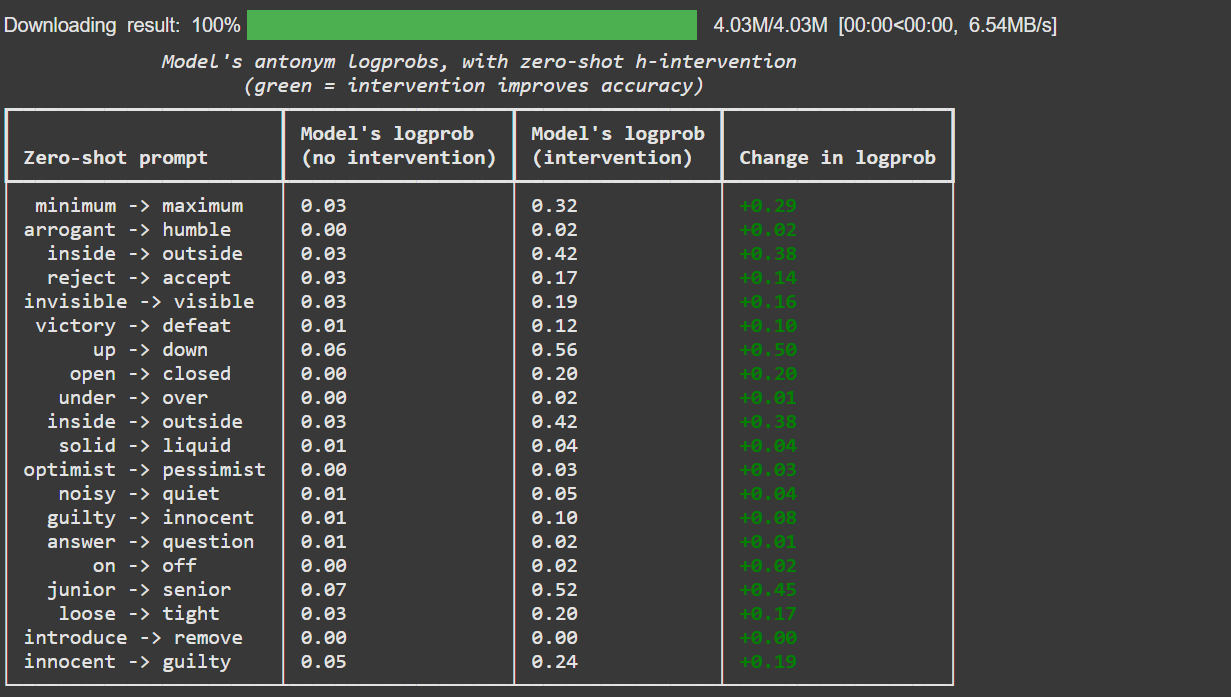

# 3️⃣ Function Vectors

> ##### Learning Objectives
>
> * Define a metric to measure the causal effect of each attention head on the correct performance of the in-context learning task
> * Understand how to rearrange activations in a model during an `nnsight` forward pass, to extract activations corresponding to a particular attention head
> * Learn how to use `nnsight` for multi-token generation

In this section, we'll replicate the crux of the paper's results, by identifying a set of attention heads whose outputs have a large effect on the model's ICL performance, and showing we can patch with these vectors to induce task-solving behaviour on randomly shuffled prompts.

We'll also learn how to use `nnsight` for multi-token generation, and steer the model's behaviour. There exist exercises where you can try this out for different tasks, e.g. the Country-Capitals task, where you'll be able to steer the model to complete prompts like `"When you think of Netherlands, you usually think of"` by talking about Amsterdam.

Note - this section structurally follows sections 2.2, 2.3 and some of section 3 from the function vectors paper.

Here, we'll move from thinking about residual stream states to thinking about the **output of specific attention heads.**

## Extracting & using FVs

### A note on `out_proj`

First, a bit of a technical complication. Most HuggingFace models don't have the nice attention head representations. What we have is the linear layer `out_proj` which implicitly combines the "projection per attention head" and the "sum over attention head" operations (if you can't see how this is possible, see the section "Attention Heads are Independent and Additive" from Anthropic's [Mathematical Framework](https://transformer-circuits.pub/2021/framework/index.html)).

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/rearrange-output-2.png" width="950">

This presents some question for us, when it comes to causal interventions on attention heads. Use the dropdowns below to read them answer these questions (they'll be important for the coming exercises).

<br>

<details>
<summary>If we want to do a causal intervention on a particular head, should we intervene on <code>z</code> (the input of <code>out_proj</code>) or on <code>attn_output</code> (the output of <code>out_proj</code>) ?</summary>

We should intervene on `z`, because we can just rearrange the `z` tensor of shape `(batch, seq, d_model)` into `(batch, seq, n_heads, d_head)`, in other words separating out all the heads. On the other hand, we can't do this with the `attn_output` because it's *already* summed over heads and we can't separate them out.

</details>

<br>

<details>
<summary>How could we get the <code>attn_output</code> vector for a single head, if we had the ability to access model weights within our context managers?</summary>

We can take a slice of the `z` tensor corresponding to a single attention head:

```python
z.reshape(batch, seq, n_heads, d_head)[:, :, head_idx]
```

and we can take a slice of the `out_proj` weight matrix corresponding to a single attention head (remember that PyTorch stores linear layers in the shape `(out_feats, in_feats)`):

```python
out_proj.weight.rearrange(d_model, n_heads, d_head)[:, head_idx]
```

then finally we can multiply these together.

</details>

<br>

<details>
<summary>How could we get the <code>attn_output</code> vector for a single head, if we </b>didn't have</b> the ability to access model weights within our context managers? (This is currently the case for <code>nnsight</code>, since having access to the weights could allow users to change them!).</summary>

We can be a bit clever, and ablate certain heads in the `z` vector before passing it through the output projection:

```python
# ablate all heads except #2 (using a cloned activation)
heads_to_ablate = [0, 1, 3, 4, ...]
z_ablated = z.reshape(batch, seq, n_heads, d_head).clone()
z_ablated[:, :, heads_to_ablate] = 0

# save the output
attn_head_output = out_proj(z_ablated).save()
```

Illustration:

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/rearrange-output-ablated-2.png" width="950">

Note - this would actually fail if `out_proj` had a bias, because we want to just get an attention head's output, not the bias term as well. But if you look at the [documentation page](https://huggingface.co/transformers/v4.11.3/_modules/transformers/models/gptj/modeling_gptj.html) you'll see that `out_proj` doesn't have a bias term, so we're all good!

</details>

### Exercise - implement `calculate_fn_vectors_and_intervene`

> ```yaml
> Difficulty: 🔴🔴🔴🔴🔴
> Importance: 🔵🔵🔵🔵🔵
>
> You should spend up to 30-60 minutes on this exercise.
> ```

This is probably the most important function in today's exercises. Implementing it will be pretty similar to the previous function `calculate_h_and_intervene`, but:

* Rather than extracting the value of the residual stream `h` at some particular layer, you'll be extracting the output of the attention heads: iterating over each layer and each head in the model.
    * You'll only need to run one clean forward pass to compute all these values, but you'll need to run a separate corrupted forward pass for each head.
* Rather than your 2 different datasets being (dataset, zero-shot dataset), your two datasets will be (dataset, corrupted version of that same dataset).
    * You can use the method `create_corrupted_dataset` method of the `ICLDataset` class for this.

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/cie-intervention.png" width="1200">

Before you actually start writing the code, it might be helpful to answer the following:

<details>
<summary>How many different <code>invoke</code> calls will you need in total?</summary>

You'll need `(N_LAYERS * N_HEADS) + 2`. To explain:

- One for the clean prompts, which you'll extract internal activations from and patch them into corrupted prompts,
- One for the corrupted prompts, which you don't intervene on,
- One for the corrupted prompts **for every attention head**, which you'll patch into using the clean run activations.

</details>

<details>
<summary>Which proxy outputs (if any) will you need to use <code>.save()</code> on, in this function?</summary>

You don't need to `.save()` the function vectors you're extracting from the model's internals, because these will only be used for causal interventions within the context manager.

The only thing you need to save is the correct token logprobs for (1) the corrupted forward pass where we don't intervene, and (2) each corrupted forward pass where we do intervene on one of the heads. In other words, you'll need to save `(N_LAYERS * N_HEADS) + 1` tensors in total.

</details>

A few other notes:

* We've added a `layers` argument, so you can iterate through different layers of the model (i.e. running the model with `layers = [3, 4, 5]` will only test the intervention on the attention heads in layers 3, 4 and 5). This is helpful if you're getting memory errors when trying to run all layers at once (remember we have 24 layers, 16 heads per layer, so even with few prompts per head this adds up fast!).
    * We've included code for you below showing how you can call the function multiple times, clearing memory between each run, then combine the results.
* When it comes to intervening, you can set the value of a reshaped tensor, i.e. `tensor.reshape(*new_shape)[index] = new_value` will change the values in `tensor` without actually reshaping it (for more on this, see the documentation for [`torch.Tensor.view`](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html)).
* It's good practice to insert a lot of assert statements in your code, to check the shapes are what you expect.
* If you're confused about dimensions, use `einops.rearrange` rather than `.reshape` - this is a wonderful tool, it's like using code annotations within your actual code!

One last note - **if this function is proving impossible to run for computational reasons, you can skip the exercise and move on to the next ones. They don't rely on this function working.** However, you should definitely at least read & understand the solution.

In [47]:
def calculate_fn_vectors_and_intervene(
    model: LanguageModel,
    dataset: ICLDataset,
    layers: list[int] | None = None,
) -> Float[Tensor, "layers heads"]:
    """
    Returns a tensor of shape (layers, heads), containing the CIE for each head.

    Inputs:
        model: LanguageModel
            the transformer you're doing this computation with
        dataset: ICLDataset
            the dataset of clean prompts from which we'll extract the function vector (we'll also create a corrupted
            version of this dataset for interventions)
        layers: list[int] | None
            the layers which this function will calculate the score for (if None, we assume all layers)
    """
    layers = range(model.config.n_layer) if (layers is None) else layers
    heads = range(model.config.n_head)

    # Get corrupted dataset
    corrupted_dataset = dataset.create_corrupted_dataset()
    N = len(dataset)

    # Get correct token ids, so we can get correct token logprobs
    correct_completion_ids = [toks[0] for toks in tokenizer(dataset.completions)["input_ids"]]

    with model.trace(remote=REMOTE) as tracer:
        # Run a forward pass on clean prompts, where we store attention head outputs
        z_dict = {}
        with tracer.invoke(dataset.prompts):
            for layer in layers:
                # Get hidden states, reshape to get head dimension, store the mean tensor
                z = model.transformer.h[layer].attn.out_proj.input[:, -1]
                z_reshaped = z.reshape(N, N_HEADS, D_HEAD).mean(dim=0)
                for head in heads:
                    z_dict[(layer, head)] = z_reshaped[head]

        # Run a forward pass on corrupted prompts, where we don't intervene or store activations (just so we can get the
        # correct-token logprobs to compare with our intervention)
        with tracer.invoke(corrupted_dataset.prompts):
            logits = model.lm_head.output[:, -1]
            correct_logprobs_corrupted = logits.log_softmax(dim=-1)[t.arange(N), correct_completion_ids].save()

        # For each head, run a forward pass on corrupted prompts (here we need multiple different forward passes, since
        # we're doing different interventions each time)
        correct_logprobs_dict = {}
        for layer in layers:
            for head in heads:
                with tracer.invoke(corrupted_dataset.prompts):
                    # Get hidden states, reshape to get head dimension, then set it to the a-vector
                    z = model.transformer.h[layer].attn.out_proj.input[:, -1]
                    z.reshape(N, N_HEADS, D_HEAD)[:, head] = z_dict[(layer, head)]
                    # Get logprobs at the end, which we'll compare with our corrupted logprobs
                    logits = model.lm_head.output[:, -1]
                    correct_logprobs_dict[(layer, head)] = logits.log_softmax(dim=-1)[
                        t.arange(N), correct_completion_ids
                    ].save()

    # Get difference between intervention logprobs and corrupted logprobs, and take mean over batch dim
    all_correct_logprobs_intervention = einops.rearrange(
        t.stack([v.value for v in correct_logprobs_dict.values()]),
        "(layers heads) batch -> layers heads batch",
        layers=len(layers),
    )
    logprobs_diff = all_correct_logprobs_intervention - correct_logprobs_corrupted.value  # shape [layers heads batch]

    # Return mean effect of intervention, over the batch dimension
    return logprobs_diff.mean(dim=-1)

<details><summary>Solution</summary>

```python
def calculate_fn_vectors_and_intervene(
    model: LanguageModel,
    dataset: ICLDataset,
    layers: list[int] | None = None,
) -> Float[Tensor, "layers heads"]:
    """
    Returns a tensor of shape (layers, heads), containing the CIE for each head.

    Inputs:
        model: LanguageModel
            the transformer you're doing this computation with
        dataset: ICLDataset
            the dataset of clean prompts from which we'll extract the function vector (we'll also create a corrupted
            version of this dataset for interventions)
        layers: list[int] | None
            the layers which this function will calculate the score for (if None, we assume all layers)
    """
    layers = range(model.config.n_layer) if (layers is None) else layers
    heads = range(model.config.n_head)

    # Get corrupted dataset
    corrupted_dataset = dataset.create_corrupted_dataset()
    N = len(dataset)

    # Get correct token ids, so we can get correct token logprobs
    correct_completion_ids = [toks[0] for toks in tokenizer(dataset.completions)["input_ids"]]

    with model.trace(remote=REMOTE) as tracer:
        # Run a forward pass on clean prompts, where we store attention head outputs
        z_dict = {}
        with tracer.invoke(dataset.prompts):
            for layer in layers:
                # Get hidden states, reshape to get head dimension, store the mean tensor
                z = model.transformer.h[layer].attn.out_proj.input[:, -1]
                z_reshaped = z.reshape(N, N_HEADS, D_HEAD).mean(dim=0)
                for head in heads:
                    z_dict[(layer, head)] = z_reshaped[head]

        # Run a forward pass on corrupted prompts, where we don't intervene or store activations (just so we can get the
        # correct-token logprobs to compare with our intervention)
        with tracer.invoke(corrupted_dataset.prompts):
            logits = model.lm_head.output[:, -1]
            correct_logprobs_corrupted = logits.log_softmax(dim=-1)[t.arange(N), correct_completion_ids].save()

        # For each head, run a forward pass on corrupted prompts (here we need multiple different forward passes, since
        # we're doing different interventions each time)
        correct_logprobs_dict = {}
        for layer in layers:
            for head in heads:
                with tracer.invoke(corrupted_dataset.prompts):
                    # Get hidden states, reshape to get head dimension, then set it to the a-vector
                    z = model.transformer.h[layer].attn.out_proj.input[:, -1]
                    z.reshape(N, N_HEADS, D_HEAD)[:, head] = z_dict[(layer, head)]
                    # Get logprobs at the end, which we'll compare with our corrupted logprobs
                    logits = model.lm_head.output[:, -1]
                    correct_logprobs_dict[(layer, head)] = logits.log_softmax(dim=-1)[
                        t.arange(N), correct_completion_ids
                    ].save()

    # Get difference between intervention logprobs and corrupted logprobs, and take mean over batch dim
    all_correct_logprobs_intervention = einops.rearrange(
        t.stack([v.value for v in correct_logprobs_dict.values()]),
        "(layers heads) batch -> layers heads batch",
        layers=len(layers),
    )
    logprobs_diff = all_correct_logprobs_intervention - correct_logprobs_corrupted.value  # shape [layers heads batch]

    # Return mean effect of intervention, over the batch dimension
    return logprobs_diff.mean(dim=-1)
```
</details>

As mentioned, the code below calls the function multiple times separately and combines the results.

When you run this code & plot the results, you should replicate Figure 3(a) in the Function Vectors paper (more or less). If the code is taking too long to run, we recommend just choosing a single layer to run, which has a distinctive pattern that can be compared to the paper's figure (e.g. layer 8, since head L8H1 has a much higher score than all the other heads in this layer).

In [48]:
dataset = ICLDataset(ANTONYM_PAIRS, size=8, n_prepended=2)


def batch_process_layers(n_layers, batch_size):
    for i in range(0, n_layers, batch_size):
        yield range(n_layers)[i : i + batch_size]


results = t.empty((0, N_HEADS), device=device)

# If this fails to run, reduce the batch size so the fwd passes are split up more, or reduce dataset size
# for layers in batch_process_layers(N_LAYERS, batch_size=4):
#     print(f"Computing layers in {layers} ...")
#     t0 = time.time()
#     results = t.concat([results, calculate_fn_vectors_and_intervene(model, dataset, layers).to(device)])
#     print(f"... finished in {time.time()-t0:.2f} seconds.\n")

Computing layers in range(0, 4) ...


KeyError: 988

In [ ]:
imshow(
    results.T,
    title="Average indirect effect of function-vector intervention on antonym task",
    width=1000,
    height=600,
    labels={"x": "Layer", "y": "Head"},
    aspect="equal",
)

### Exercise - calculate the function vector

> ```yaml
> Difficulty: 🔴🔴🔴🔴🔴
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 25-50 minutes on this exercise.
> ```

Your next task is to actually calculate and return the function vector, so we can do a few experiments with it. The function vector is the sum of the outputs of all the attention heads we found using the previous function (i.e. the sum of all of the vectors these heads write to the residual stream), averaged over the prompts in our dataset.

There's a difficulty here - rather than just getting the `z` vectors, we're actually trying to get the `attn_out` vectors, but *before* they're summed over heads. As we discussed previously, this is a bit tricky to do for the model we're working with, because the `out_proj` linear map actually does the "project up" and "sum over heads" operations simultaneously. It would be nice to just take a slice of the `out_proj` matrix and multiply it with a slice of the `z` vector, but the `nnsight` library doesn't yet allow users to access weights directly (for security reasons). To understand how we can extract the `attn_out` vector for a head separately without accessing the underlying weights, you should go back to read the subsection **A note on `out_proj`** at the start of this section.

In [49]:
def calculate_fn_vector(
    model: LanguageModel,
    dataset: ICLDataset,
    head_list: list[tuple[int, int]],
) -> Float[Tensor, "d_model"]:
    """
    Returns a vector of length `d_model`, containing the sum of vectors written to the residual stream
    by the attention heads in `head_list`, averaged over all inputs in `dataset`.

    Inputs:
        model: LanguageModel
            the transformer you're doing this computation with
        dataset: ICLDataset
            the dataset of clean prompts from which we'll extract the function vector (we'll also create a
            corrupted version of this dataset for interventions)
        head_list: list[tuple[int, int]]
            list of attention heads we're calculating the function vector from
    """
    # raise NotImplementedError()
    # How does account for both single heads and a layer of heads?
    # Turn head_list into a dict of {layer: heads we need in this layer}
    head_dict = defaultdict(set)
    for layer, head in head_list:
        head_dict[layer].add(head)

    fn_vector_list = []

    with model.trace(dataset.prompts, remote=REMOTE):
        for layer, head_list in head_dict.items():
            # Get the output projection layer
            out_proj = model.transformer.h[layer].attn.out_proj

            # Get the mean output projection input (note, setting values of this tensor will not have
            # downstream effects on other tensors)
            hidden_states = out_proj.input[:, -1].mean(dim=0)

            # Zero-ablate all heads which aren't in our list, then get the output (which
            # will be the sum over the heads we actually do want!)
            heads_to_ablate = set(range(N_HEADS)) - head_dict[layer]
            for head in heads_to_ablate:
                hidden_states.reshape(N_HEADS, D_HEAD)[head] = 0.0

            # Now that we've zeroed all unimportant heads, get the output & add it to the list
            # (we need a single batch dimension so we can use `out_proj`)
            out_proj_output = out_proj(hidden_states.unsqueeze(0)).squeeze()
            fn_vector_list.append(out_proj_output.save())

    # We sum all attention head outputs to get our function vector
    fn_vector = sum([v.value for v in fn_vector_list])

    assert fn_vector.shape == (D_MODEL,)
    return fn_vector

tests.test_calculate_fn_vector(calculate_fn_vector, model)

Testing for single head ... 


tests for single head passed.
Testing for multiple heads ... 


tests for multiple heads passed.

All tests in `test_calculate_fn_vector` passed.


In [ ]:
!df -h

<details><summary>Solution</summary>

```python
def calculate_fn_vector(
    model: LanguageModel,
    dataset: ICLDataset,
    head_list: list[tuple[int, int]],
) -> Float[Tensor, "d_model"]:
    """
    Returns a vector of length `d_model`, containing the sum of vectors written to the residual stream
    by the attention heads in `head_list`, averaged over all inputs in `dataset`.

    Inputs:
        model: LanguageModel
            the transformer you're doing this computation with
        dataset: ICLDataset
            the dataset of clean prompts from which we'll extract the function vector (we'll also create a
            corrupted version of this dataset for interventions)
        head_list: list[tuple[int, int]]
            list of attention heads we're calculating the function vector from
    """
    # Turn head_list into a dict of {layer: heads we need in this layer}
    head_dict = defaultdict(set)
    for layer, head in head_list:
        head_dict[layer].add(head)

    fn_vector_list = []

    with model.trace(dataset.prompts, remote=REMOTE):
        for layer, head_list in head_dict.items():
            # Get the output projection layer
            out_proj = model.transformer.h[layer].attn.out_proj

            # Get the mean output projection input (note, setting values of this tensor will not have
            # downstream effects on other tensors)
            hidden_states = out_proj.input[:, -1].mean(dim=0)

            # Zero-ablate all heads which aren't in our list, then get the output (which
            # will be the sum over the heads we actually do want!)
            heads_to_ablate = set(range(N_HEADS)) - head_dict[layer]
            for head in heads_to_ablate:
                hidden_states.reshape(N_HEADS, D_HEAD)[head] = 0.0

            # Now that we've zeroed all unimportant heads, get the output & add it to the list
            # (we need a single batch dimension so we can use `out_proj`)
            out_proj_output = out_proj(hidden_states.unsqueeze(0)).squeeze()
            fn_vector_list.append(out_proj_output.save())

    # We sum all attention head outputs to get our function vector
    fn_vector = sum([v.value for v in fn_vector_list])

    assert fn_vector.shape == (D_MODEL,)
    return fn_vector
```
</details>

## Multi-token generation

We're now going to replicate some of the results in Table 3, in the paper:

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/tab3.png" width="700">

This will involve doing something we haven't done before - **intervening on multi-token prompt generation**.

Most of the interpretability exercises in this chapter have just consisted of running single forward passes, rather than autoregressive text generation. But we're trying something different here: we're adding the function vector to the final sequence position at each forward pass during text generation, and seeing if we can get the model to output a sentence with a different meaning.

The results of Table 3 came from adding the function vector to the residual stream at the final sequence position of the original prompt, **and the final sequence position for each subsequent generation.** The reason we do this is to guide the model's behaviour over time. Our hypothesis is that the function vector induces "next-token antonym behaviour" (because it was calculated by averaging attention head outputs at the sequence position before the model made its antonym prediction in the ICL prompts).

### Using `nnsight` for multi-token generation

Previously, our context managers have looked like:

```python
# Single invoke
with model.trace(prompt, remote=REMOTE):
    ... # Intervene on fwd pass

# Multiple invokes
with model.trace(remote=REMOTE) as tracer:
    with tracer.invoke(prompt):
        ... # Intervene on fwd pass
```

But for multi-token generation, we'll be using the `generate` method rather than `trace`. Our context managers will look like:

```python
# Single invoke
with model.generate(prompt, remote=REMOTE, max_new_tokens=max_new_tokens):
    for n in range(max_new_tokens):
        ... # Intervene on fwd pass for n-th token to be generated
        model.next()

# Multiple invokes
with model.generate(max_new_tokens=max_new_tokens, remote=REMOTE) as generator:
    with generator.invoke(prompt):

        for n in range(max_new_tokens):
            ... # Intervene on fwd pass for n-th token to be generated
            model.next()
```

The line `model.next()` denotes that the following interventions should be applied to the forward pass which generates the *next* token.

Mostly, everything you learned during single-token generation generalizes to the multi-token case. For example, using `.save()` still saves proxies outside the context managers (although make sure that you don't use the same variable names over different generations, otherwise you'll overwrite them - it's easier to store your saved proxies in e.g. a list or dict).

Note that `model.generate` takes the same arguments as the normal [HuggingFace generate method](https://huggingface.co/docs/transformers/en/main_classes/text_generation). This means we can use arguments like `top_k`, `top_p`, or `repetition_penalty` to control generation behaviour. In the exercises below we use a repetition penalty (we choose a value of 1.2, in line with the [paper](https://arxiv.org/pdf/1909.05858) that suggested it) - this can avoid the model falling into loops of repeating the same sequence, which is especially common in steering when we're pushing the model OOD.

<!-- #### Optional questions - multi-token generation with NNsight

Here are a few quick optional questions to test your understanding of how multi-generation works with NNsight. These are non-essential, and only mentioned here as potentially helpful pointers.  


<details>
<summary>How do I add vector <code>h</code> to all the tokens in the original prompt but not to the generated tokens? </summary>

```python
with model.generate(max_new_tokens=max_new_tokens, remote=REMOTE) as generator:
    with generator.invoke(prompt):
        # Add vectors to the model's internals on the first forward pass
        model.transformer.h[layer].output[0][:, :seq_len] += h

```
You don't have to call `model.next()` because you're only adding the vector once to tokens in the original prompt. This will be cached when the model is subsequently generating tokens.

</details>

<details>
<summary>How do I intervene with vector <code>h</code> during the generation of the first k generated tokens? </summary>

To intervene during the generation of the first `k` generated tokens:
```python
with model.generate(max_new_tokens=max_new_tokens, remote=REMOTE) as generator:
    with generator.invoke(prompt):

        for n in range(k+1):
            # Add vector to the model's internals, on the k-th forward pass
            model.transformer.h[layer].output[0] += h
            model.next()
```
When `n=0`, you are adding to tokens in the original prompt before a new token is a generated. After calling `model.next()`, you are accessing the hidden state of the last token that was generated (with seq_len=1).

</details>

</details>

<details>
<summary>How do I intervene with vector <code>h</code> only during the generation of the first k tokens, but not to tokens in the original prompt before the first generated token? </summary>

```python
with model.generate(max_new_tokens=max_new_tokens, remote=REMOTE) as generator:
    with generator.invoke(prompt):

        for n in range(k+1):
            model.next()
            # Add vector AFTER calling model.next() to add to the token that just got generated
            model.transformer.h[layer].output[0] += h

```
By not adding things before `model.next()`, we never add to the original prompt but always after a new token has been generated.

</details>

</details>

<details>
<summary>What is the difference between adding vector <code>h</code> before and after vector <code>model.next()</code>? </summary>

As explained in Q3, adding vector before `model.next()` means the operation is always done to the current sequence **before** a new generated token is appended. Adding vector after `model.next()` means the operation is always done to the newly generated token.

</details> -->

### Key-Value Caching

TLDR - caching can make causal interventions inside `model.generate` more complicated, but if you only intervene on sequence positions other than the very last one. In our exercises, we'll only be intervening on the last seqpos so you don't need to worry about it, but it's still a useful topic to understand.

<details>
<summary>See this dropdown if you're curious for more details.</summary>

To speed up inference, transformer models perform **key-value caching** to speed up text generation. This means that the time taken to generate $n$ tokens is ***much*** less than $n$ times longer than generating a single token. See [this blog post](https://kipp.ly/transformer-inference-arithmetic/) for more on transformer inference arithmetic.

When caching takes place, and we're doing causal interventions, we have to be careful that the caching won't override our causal interventions. Sometimes caching has to be disabled to make sure that our causal intervention works correctly. For example, if we wanted to perform the intervention "add the function vector to *only* the final sequence position of the prompt for each token we generate" then we'd have to disable caching (since previous forward passes would contain cached values where we intervened on a sequence position which is no longer the final sequence position). However, here we're performing the intervention "add the function vector to the final token of the original prompt, and to *all subsequent sequence positions*", meaning enabling caching (the default behaviour) will give us the right causal intervention.

</details>

### Generator Output

The object `generator.output` is by default a tensor which contains the model's token ID completions (not the logits).

By default the `generate` method will generate tokens greedily, i.e. always taking the maximum-probability token at each step. For now, we don't need to worry about changing this behaviour. But in future exercises we'll experiment with different sampling methods than greedy sampling (which generate uses by default), so `generator.output` and argmaxing over logits will not be identical!

### Exercise - intervene with function vector, in multi-token generation

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to 15-30 minutes on this exercise.
> ```

You should now fill in the function `intervene_with_fn_vector` below. This will take a function vector (calculated from the function you wrote above), as well as a few other arguments (see docstring), and return the model's string completion on the given prompt template.

We hope to observe results qualitatively like the ones in Table 3, i.e. having the model define a particular word as its antonym.

In [ ]:
def intervene_with_fn_vector(
    model: LanguageModel,
    word: str,
    layer: int,
    fn_vector: Float[Tensor, "d_model"],
    prompt_template='The word "{x}" means',
    n_tokens: int = 5,
) -> tuple[str, str]:
    """
    Intervenes with a function vector, by adding it at the last sequence position of a generated prompt.

    Inputs:
        model: LanguageModel
            the transformer you're doing this computation with
        word: str
            The word which is substituted into the prompt template, via prompt_template.format(x=word)
        layer: int
            The layer we'll make the intervention (by adding the function vector)
        fn_vector: Float[Tensor, "d_model"]
            The vector we'll add to the final sequence position for each new token to be generated
        prompt_template:
            The template of the prompt we'll use to produce completions
        n_tokens: int
            The number of additional tokens we'll generate for our unsteered / steered completions

    Returns:
        completion: str
            The full completion (including original prompt) for the no-intervention case
        completion_intervention: str
            The full completion (including original prompt) for the intervention case
    """
    prompt = prompt_template.format(x=word)

    with model.generate(max_new_tokens=n_tokens, remote=REMOTE) as generator:

      # uninvervened
      with generator.invoke(prompt):
        for i in range(n_tokens-1):
          model.next()
        tokens = model.generator.output.save()

      # Intervention
      with generator.invoke(prompt):
        for i in range(n_tokens-1):
          model.transformer.h[layer].output[0][0, -1] += fn_vector
          model.next()
        tokens_intervened = model.generator.output.save()
    completion, completion_intervention = tokenizer.batch_decode([tokens.squeeze().tolist(), tokens_intervened.squeeze().tolist()])
    return completion, completion_intervention

<details><summary>Solution</summary>

```python
def intervene_with_fn_vector(
    model: LanguageModel,
    word: str,
    layer: int,
    fn_vector: Float[Tensor, "d_model"],
    prompt_template='The word "{x}" means',
    n_tokens: int = 5,
) -> tuple[str, str]:
    """
    Intervenes with a function vector, by adding it at the last sequence position of a generated prompt.

    Inputs:
        model: LanguageModel
            the transformer you're doing this computation with
        word: str
            The word which is substituted into the prompt template, via prompt_template.format(x=word)
        layer: int
            The layer we'll make the intervention (by adding the function vector)
        fn_vector: Float[Tensor, "d_model"]
            The vector we'll add to the final sequence position for each new token to be generated
        prompt_template:
            The template of the prompt we'll use to produce completions
        n_tokens: int
            The number of additional tokens we'll generate for our unsteered / steered completions

    Returns:
        completion: str
            The full completion (including original prompt) for the no-intervention case
        completion_intervention: str
            The full completion (including original prompt) for the intervention case
    """
    prompt = prompt_template.format(x=word)

    with model.generate(remote=REMOTE, max_new_tokens=n_tokens, repetition_penalty=1.2) as generator:
        with generator.invoke(prompt):
            for _ in range(n_tokens - 1):
                model.next()
            tokens = model.generator.output.save()

        with generator.invoke(prompt):
            for _ in range(n_tokens):
                model.transformer.h[layer].output[0][0, -1] += fn_vector
                model.next()
            tokens_intervention = model.generator.output.save()

    completion, completion_intervention = tokenizer.batch_decode(
        [tokens.value.squeeze().tolist(), tokens_intervention.value.squeeze().tolist()]
    )
    return completion, completion_intervention
```
</details>

To test your function, run the code below. You should find that the first completion seems normal, but the second completion defines a word as its antonym (you might have to play around a bit with the scale factor of `fn_vector`, to balance between effectiveness and coherence of output). If this works, congratulations - **you've just successfully induced an OOD behavioural change in a 6b-parameter model!**

In [ ]:
# Remove word from our pairs, so it can be a holdout
word = "light"
_ANTONYM_PAIRS = [pair for pair in ANTONYM_PAIRS if word not in pair]

# Define our dataset, and the attention heads we'll use
dataset = ICLDataset(_ANTONYM_PAIRS, size=20, n_prepended=5)
head_list = [
    (8, 0),
    (8, 1),
    (9, 14),
    (11, 0),
    (12, 10),
    (13, 12),
    (13, 13),
    (14, 9),
    (15, 5),
    (16, 14),
]

# Extract the function vector
fn_vector = calculate_fn_vector(model, dataset, head_list)

# Intervene with the function vector
completion, completion_intervention = intervene_with_fn_vector(
    model,
    word=word,
    layer=9,
    fn_vector=0.1 * fn_vector,
    prompt_template='The word "{x}" means',
    n_tokens=40,
)

table = Table("No intervention", "intervention")
table.add_row(repr(completion), repr(completion_intervention))
rprint(table)

### Exercise - generalize results to another task (optional)

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 15-30 minutes on this exercise.
> ```

In this exercise, you get to pick a task different to the antonyms task, and see if the results still hold up (for the same set of attention heads).

We'll leave this exercise fairly open-ended, without any code templates for you to fill in. However, if you'd like some guidance you can use the dropdown below.

<details>
<summary>Guidance for exercise</summary>

Whatever your task, you'll want to generate a new set of words. You can repurpose the `generate_dataset` function from the antonyms task, by supplying a different prompt and initial set of examples (this will require generating & using an OpenAI api key, if you haven't already), or you can just find an appropriate dataset online.

When you define the `ICLDataset`, you might want to use `bidirectional=False`, if your task isn't symmetric. The antonym task is symmetric, but others (e.g. the Country-Capitals task) are not.

You'll need to supply a new prompt template for the `intervene_with_fn_vector` function, but otherwise most of your code should stay the same.

</details>

In [ ]:
with open(section_dir / "data/country_capital_pairs.txt", "r", encoding="utf-8") as f:
    COUNTRY_CAPITAL_PAIRS = [line.split() for line in f.readlines()]

country = "Netherlands"
_COUNTRY_CAPITAL_PAIRS = [pair for pair in COUNTRY_CAPITAL_PAIRS if pair[0] != country]

dataset = ICLDataset(_COUNTRY_CAPITAL_PAIRS, size=20, n_prepended=5, bidirectional=False)
head_list = [
    (8, 0),
    (8, 1),
    (9, 14),
    (11, 0),
    (12, 10),
    (13, 12),
    (13, 13),
    (14, 9),
    (15, 5),
    (16, 14),
]

fn_vector = calculate_fn_vector(model, dataset, head_list)

# Intervene with the function vector
completion, completion_intervention = intervene_with_fn_vector(
    model=model,
    word=country,
    layer=9,
    fn_vector=0.05 * fn_vector,
    prompt_template="When you think of {x},",
    n_tokens=40,
)

table = Table("No intervention", "intervention")
table.add_row(repr(completion), repr(completion_intervention))
rprint(table)

# 4️⃣ Steering Vectors in GPT2-XL

> ##### Learning Objectives
>
> * Understand the goals & main results from Alex Turner et al's work on steering vectors
> * Reproduce the changes in behaviour described in their initial post

**Note**: GPT2-XL is not hosted remotely by NNsight at the moment. If you use GPT2-XL, we recommend setting `REMOTE = False`. Otherwise, you can use one of the remotely hosted models (see [here](https://nnsight.net/status/)) and set `REMOTE = True`.

## Steering model behaviour

In the final non-bonus exercise of the previous section, we touched on the idea of using function vectors to induce behavioural changes in the model's completions, rather than specifically making it solve zero-shot or corrupted prompts with the right completion. In these next exercises, we'll explore this kind of work in more detail. We'll be primarily using Turner et al's work on [Steering GPT-2-XL by adding an activation vector](https://www.lesswrong.com/posts/5spBue2z2tw4JuDCx/steering-gpt-2-xl-by-adding-an-activation-vector).

Summary of the way in which this work differs from the function vector work we've done so far:

* Function vectors focused on the model performing a particular function (e.g. mapping a word to its opposite), whereas this work focuses on behavioural changes (e.g. completing a prompt which has negative tone in a positive way).
* Function vectors work looked at very large models (our exercises used Pythia-7B, the smallest model which was examined in the function vectors paper). This particular steering vectors post focused on the smaller models GPT2-Small (85m) and GPT2-XL (1.5B). We'll be focusing on GPT2-XL.
* The second half of our function vectors work identified important attention heads and focused on their outputs, rather than just adding to the residual stream directly. In this steering vector setup, we'll go back to the simpler method of adding directly into the residual stream.

Despite these differences, much of the work which was done here overlaps with function vector work, since they both fall into the broader category of *"finding vectors using forward-pass-based methods (i.e. not with SGD) and using them to intervene on models during forward passes & change the model's output"*. This description would also include the following:

* [Inference-time intervention](https://www.lesswrong.com/posts/kuQfnotjkQA4Kkfou/inference-time-intervention-eliciting-truthful-answers-from), which focuses on inducing the behavioural change of "making the model tell the truth". It also looks at other non-forward-pass-based techniques for finding an intervention vector, e.g. CCS and linear probing, although it concludes that forward-pass-based methods similar to the ones we've been using so far work the best.
* [Steering Llama 2 via Contrastive Activation Addition](https://arxiv.org/abs/2312.06681), which can be thought of as an extension of the GPT2-XL steering vector work to larger models, specifically Llama 2 13B. It also takes more of a high-level evals framework; measuring the model's change in attributes such as sycophancy, myopia, and power-seeking (finding that these attributes can be increased or decreased by adding the appropriate vectors).

We'll discuss some of this work more in the bonus section, but for now, let's get on with the exercises!

First, we'll load in GPT2-XL, then we'll replicate some of the examples in the main post.

In [77]:
# gpt2_xl = LanguageModel("gpt2-xl", device_map="auto", torch_dtype=t.bfloat16)
gpt2_xl = LanguageModel("deepseek-ai/DeepSeek-R1-Distill-Llama-8B", device_map="auto", torch_dtype=t.bfloat16)

tokenizer = gpt2_xl.tokenizer

# REMOTE = False
REMOTE = True

# If you are using gpt2_xl, set REMOTE = False as gpt2_xl is not hosted remotely by nnsight. You can
# set REMOTE = True for a remotely hosted model here (https://nnsight.net/status/)

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

### Exercise - replicate the steering vector results

> ```yaml
> Difficulty: 🔴🔴🔴🔴🔴
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to 30-50 minutes on this exercise.
> ```

Replicate the results in the LessWrong post [Steering GPT-2-XL by adding an activation vector](https://www.lesswrong.com/posts/5spBue2z2tw4JuDCx/steering-gpt-2-xl-by-adding-an-activation-vector#fnrefcvnfx3e6sfu); specifically the "demonstrations of additions that work well" section.

Read the "How activation additions work" section of [Steering GPT-2-XL by adding an activation vector](https://www.lesswrong.com/posts/5spBue2z2tw4JuDCx/steering-gpt-2-xl-by-adding-an-activation-vector#How_activation_additions_work) to understand how vectors are extracted and added. We've provided a function template as well as some example code to run; your main job will be to fill in the function. This will be like a hybrid of several previous exercises (with most similarity to the function `calculate_and_intervene_with_h`), although there will be a few methodological differences.

This is the last exercise in this set, and hopefully it'll provide an opportunity to draw together all the threads of what you've learned so far!

### Caching

This is a different kind of causal intervention than we performed in previous sections. Rather than adding a single vector to the final sequence position at each token generation, we're adding a slice of vectors to the first sequence positions of the original prompt (see tables like in [this section](https://www.lesswrong.com/posts/5spBue2z2tw4JuDCx/steering-gpt-2-xl-by-adding-an-activation-vector#1__Love___Hate) for an illustration). How do you think this will affect our function? Should we still cache? Should we be using `.generate()` or `.trace()`? If using `.generate()`, do we need to call `model.next()` ?

<details>
<summary>Click this dropdown for answers to the questions above.</summary>

Rather than adding to each final sequence position for every token generated, we just add the vectors once, to the end of the prompt. This means that:

- We can still use caching (because the values we cache shouldn't be different in subsequent token generations),
- We should be using `.generate()` (because we're doing multi-token generation),
- We don't need to call `model.next()` (because we only intervene once, and our intervention will be cached & applied to all subsequent tokens which are generated).

Again, if any of this is confusing then please ask a TA or message in the Slack channel.

</details>

### Padding

The [tables](https://www.lesswrong.com/posts/5spBue2z2tw4JuDCx/steering-gpt-2-xl-by-adding-an-activation-vector#1__Love___Hate) show the activations being added on the left (i.e. the sequences are padded on the right), but by default padding is applied on the left. There are 2 possible ways you can get around this:

1. Right-pad the input sequences manually, i.e. use something like `len(tokenizer.tokenize(prompt))` to see how long each of the prompts is, and add copies of `tokenizer.pad_token` to the end of each sequence.
2. Don't manually pad the input sequences, instead slice the sequences you add to the original prompt from the right side of the activation addition sequences, rather than from the left side.

The solutions use (2), but you can use either of these methods.

### Sampling

Following the post, we'll use top-p sampling with probability 0.3 to generate our sequences. We'll also use a small frequency penalty to penalize repetition (so the model gets stuck in loops less). If you've done earlier exercises in this section then you might have implemented `freq_penalty` during sampling; this is supported by TransformerLens models, but HuggingFace uses the somewhat similar `repetition_penalty` (default value is 1.0 indicating no penalty, values higher than 1.0 apply a penalty to repeated tokens).

We apply these sampling methods by passing keyword arguments into the `generate` method:

```python
{
    "do_sample": True, # necessary whenever we're sampling rather than doing greedy decoding
    "top_p": 0.3,
    "repetition_penalty": 1.1,
}
```

Note that the sequences are generated stochastically rather than greedily - this means we'll get different results if we input multiple different copies of the same sequence. We've given you the `n_comparisons` argument in the function below, i.e. you should generate this many steered *and* this many unsteered completions.

### Other tips / notes

We recommend starting with example #9 (the "talking about weddings" one). It seems quite robust to the exact conditions of the forward pass, unlike the `Love - Hate` example. You can use any of the template cells we've given you below.

We've given you a `use_bos` argument; if this is True then you should append `tokenizer.bos_token` to the start of all the prompts. This is just to be true to the LessWrong post's implementation; it won't change behaviour much and you can probably ignore it and still get good results.

In [82]:
SAMPLING_KWARGS = {
    "do_sample": True,
    "top_p": 0.3,
    "repetition_penalty": 1.2,
}


def calculate_and_apply_steering_vector(
    model: LanguageModel,
    prompt: str,
    activation_additions: list[tuple[int, float, str]],
    n_tokens: int,
    n_comparisons: int = 1,
    use_bos: bool = True,
) -> tuple[list[str], list[str]]:
    """
    Performs the steering vector experiments described in the LessWrong post.

    Args:
        model: LanguageModel
            the transformer you're doing this computation with
        prompt: str
            The original prompt, which we'll be doing activation steering on.

        activation_additions: list[tuple[int, float, str]], each tuple contains:
            layer - the layer we're applying these steering vectors to
            coefficient - the value we're multiplying it by
            prompt - the prompt we're inputting
            e.g. activation_additions[0] = [6, 5.0, " Love"] means we add the " Love" vector at layer 6, scaled by 5x

        n_tokens: int
            Number of tokens which will be generated for each completion

        n_comparisons: int
            Number of sequences generated in this function (i.e. we generate `n_comparisons` which are unsteered, and
            the same number which are steered).

    Returns:
        unsteered_completions: list[str]
            List of length `n_comparisons`, containing all the unsteered completions.

        steered_completions: list[str]
            List of length `n_comparisons`, containing all the steered completions.
    """
    # Add the BOS token manually, if we're including it
    if use_bos:
        bos = model.tokenizer.bos_token
        prompt = bos + prompt
        activation_additions = [[layer, coeff, bos + p] for layer, coeff, p in activation_additions]
    # Get the (layers, coeffs, prompts) in an easier form to use, also calculate the prompt lengths & check they're all the same
    act_layers, act_coeffs, act_prompts = zip(*activation_additions)
    act_seq_lens = [len(tokenizer.tokenize(act_prompt)) for act_prompt in act_prompts]
    assert len(set(act_seq_lens)) == 1, "not all same length"
    # Get the prompts we'll intervene on (unsteered and steered)
    unsteered_prompts = [prompt for _ in range(len(act_prompts))]
    steered_prompts = [prompt for _ in range(len(act_prompts))]

    with model.generate(max_new_tokens=n_tokens, remote=REMOTE, **SAMPLING_KWARGS) as generator:
        # Run the act_add prompts (i.e. the contrast pairs), and extract their activations
        with generator.invoke(act_prompts):
            # Get all the prompts from the activation additions, and put them in a list
            # (note, we slice from the end of the sequence because of left-padding)
            try:
              activations_to_add = [model.transformer.h[act_layer].output[0][i, -act_seq_len:] for i, (act_layer, act_seq_len) in enumerate(zip(act_layers, act_seq_lens))]
            except:
               activations_to_add = [model.model.layers[act_layer].output[0][i, -act_seq_len:] for i, (act_layer, act_seq_len) in enumerate(zip(act_layers, act_seq_lens))]
            # use as proxies, shape [1*act_seq_len*model_dim]
        # Forward pass on unsteered prompts (no intervention, no activations saved - we only need the completions)
        with generator.invoke(unsteered_prompts):
            unsteered_completions = model.generator.output.save()

        # Forward pass on steered prompts (we add in the results from the act_add prompts)
        with generator.invoke(steered_prompts):
            # For each act_add prompt, add the vector to residual stream, at the start of the sequence
            for i, (act_layer, act_coeff, act_seq_len) in enumerate(zip(act_layers, act_coeffs, act_seq_lens)):
              try:
                model.transformer.h[act_layer].output[0][:, :act_seq_len] += act_coeff*activations_to_add[i]
              except:
                model.model.layers[act_layer].output[0][:, :act_seq_len] += act_coeff*activations_to_add[i]
            steered_completions = model.generator.output.save()

    # Decode steered & unsteered completions (discarding the sequences we only used for extracting activations) & return results
    unsteered_completions = tokenizer.batch_decode(unsteered_completions[-n_comparisons:])
    steered_completions = tokenizer.batch_decode(steered_completions[-n_comparisons:])
    return unsteered_completions, steered_completions

<details><summary>Solution</summary>

```python
SAMPLING_KWARGS = {
    "do_sample": True,
    "top_p": 0.3,
    "repetition_penalty": 1.2,
}


def calculate_and_apply_steering_vector(
    model: LanguageModel,
    prompt: str,
    activation_additions: list[tuple[int, float, str]],
    n_tokens: int,
    n_comparisons: int = 1,
    use_bos: bool = True,
) -> tuple[list[str], list[str]]:
    """
    Performs the steering vector experiments described in the LessWrong post.

    Args:
        model: LanguageModel
            the transformer you're doing this computation with
        prompt: str
            The original prompt, which we'll be doing activation steering on.

        activation_additions: list[tuple[int, float, str]], each tuple contains:
            layer - the layer we're applying these steering vectors to
            coefficient - the value we're multiplying it by
            prompt - the prompt we're inputting
            e.g. activation_additions[0] = [6, 5.0, " Love"] means we add the " Love" vector at layer 6, scaled by 5x

        n_tokens: int
            Number of tokens which will be generated for each completion

        n_comparisons: int
            Number of sequences generated in this function (i.e. we generate `n_comparisons` which are unsteered, and
            the same number which are steered).

    Returns:
        unsteered_completions: list[str]
            List of length `n_comparisons`, containing all the unsteered completions.

        steered_completions: list[str]
            List of length `n_comparisons`, containing all the steered completions.
    """
    # Add the BOS token manually, if we're including it
    if use_bos:
        bos = model.tokenizer.bos_token
        prompt = bos + prompt
        activation_additions = [[layer, coeff, bos + p] for layer, coeff, p in activation_additions]

    # Get the (layers, coeffs, prompts) in an easier form to use, also calculate the prompt lengths & check they're all the same
    act_add_layers, act_add_coeffs, act_add_prompts = zip(*activation_additions)
    act_add_seq_lens = [len(tokenizer.tokenize(p)) for p in act_add_prompts]
    assert len(set(act_add_seq_lens)) == 1, "All activation addition prompts must be the same length."
    assert act_add_seq_lens[0] <= len(
        tokenizer.tokenize(prompt)
    ), "All act_add prompts should be shorter than original prompt."

    # Get the prompts we'll intervene on (unsteered and steered)
    steered_prompts = [prompt for _ in range(n_comparisons)]
    unsteered_prompts = [prompt for _ in range(n_comparisons)]

    with model.generate(max_new_tokens=n_tokens, remote=REMOTE, **SAMPLING_KWARGS) as generator:
        # Run the act_add prompts (i.e. the contrast pairs), and extract their activations
        with generator.invoke(act_add_prompts):
            # Get all the prompts from the activation additions, and put them in a list
            # (note, we slice from the end of the sequence because of left-padding)
            act_add_vectors = [
                model.transformer.h[layer].output[0][i, -seq_len:]
                for i, (layer, seq_len) in enumerate(zip(act_add_layers, act_add_seq_lens))
            ]

        # Forward pass on unsteered prompts (no intervention, no activations saved - we only need the completions)
        with generator.invoke(unsteered_prompts):
            unsteered_out = model.generator.output.save()

        # Forward pass on steered prompts (we add in the results from the act_add prompts)
        with generator.invoke(steered_prompts):
            # For each act_add prompt, add the vector to residual stream, at the start of the sequence
            for i, (layer, coeff, seq_len) in enumerate(zip(act_add_layers, act_add_coeffs, act_add_seq_lens)):
                model.transformer.h[layer].output[0][:, :seq_len] += coeff * act_add_vectors[i]
            steered_out = model.generator.output.save()

    # Decode steered & unsteered completions (discarding the sequences we only used for extracting activations) & return results
    unsteered_completions = tokenizer.batch_decode(unsteered_out[-n_comparisons:])
    steered_completions = tokenizer.batch_decode(steered_out[-n_comparisons:])

    return unsteered_completions, steered_completions
```
</details>

To test your function, use any of the following code snippets (as mentioned, we recommend starting with the weddings example, since the results tend to be pretty robust).

In [83]:
# non-REMOTE takes too long
unsteered_completions, steered_completions = calculate_and_apply_steering_vector(
    gpt2_xl,
    prompt="I hate you because",
    activation_additions=[(6, +5.0, "Love "), (6, -5.0, "Hate")],
    n_tokens=50,
    n_comparisons=3,
    use_bos=True,
)

table = Table("Unsteered", "Steered", title="Completions", show_lines=True)
for usc, sc in zip(unsteered_completions, steered_completions):
    table.add_row(usc, sc)
rprint(table)

                                                    Completions                                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Unsteered                                              ┃ Steered                                                ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ <｜begin▁of▁sentence｜><｜begin▁of▁sentence｜>I hate   │ <｜begin▁of▁sentence｜><｜begin▁of▁sentence｜>I hate   │
│ you because I can't have you forever, but I love you   │ you because I can't have you forever, but I love you   │
│ because I do.                                          │ so much. It's a paradoxical situation.                 │
│ Wait, that doesn’t make sense. If someone says they    │ Okay, so I'm trying to figure out how to respond to    │
│ both hate and love me, maybe it's a paradox or         │ this person who says they both hate me and love me at  │
│ something.                                             │ the same time.                                         │
│                                                        │                                                        │
│ But in this case, the person is saying                 │                                                        │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ <｜begin▁of▁sentence｜><｜begin▁of▁sentence｜>I hate   │ <｜begin▁of▁sentence｜><｜begin▁of▁sentence｜>I hate   │
│ you because I can't have my own children here. But     │ you because I can't have you forever, but I love you   │
│ wait, maybe it's not about that.                       │ so much. It's a paradoxical situation.                 │
│                                                        │ Okay, so I'm trying to figure out how to respond to    │
│ Wait, no, the real reason is different. Let me think   │ this person who says they both hate me and love me at  │
│ again.                                                 │ the same time.                                         │
│                                                        │                                                        │
│ Maybe it's because of something else... Hmm.           │                                                        │
│                                                        │                                                        │
│ Oh! It must be because                                 │                                                        │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

In [105]:
unsteered_completions, steered_completions = calculate_and_apply_steering_vector(
    gpt2_xl,
    prompt="I went up to my friend and said",
    activation_additions=[
        (20, +4.0, "I always talk about weddings constantly"),
        (20, -4.0, "I never talk about weddings constantly"),
    ],
    n_tokens=50,
    n_comparisons=3,
    use_bos=True,
)

table = Table("Unsteered", "Steered", title="Completions", show_lines=True)
for usc, sc in zip(unsteered_completions, steered_completions):
    table.add_row(usc, sc)
rprint(table)

                                                    Completions                                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Unsteered                                              ┃ Steered                                                ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ <｜begin▁of▁sentence｜><｜begin▁of▁sentence｜>I went   │ <｜begin▁of▁sentence｜><｜begin▁of▁sentence｜>I went   │
│ up to my friend and said, "Hey, can I borrow your      │ up to my friend and said, "Hey, can I borrow your      │
│ ladder?" He said, "Sure." So I took it home. Then he   │ ladder?" He said, "Sure." So I took it home. Then he   │
│ asked me later if I needed help moving something else. │ asked me later why didn't I bring it back? Hmm.        │
│ Wait, that doesn't make sense. If you take the ladder  │                                                        │
│ without asking                                         │ Wait a minute, maybe that's not the right approach.    │
│                                                        │ Maybe                                                  │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ <｜begin▁of▁sentence｜><｜begin▁of▁sentence｜>I went   │ <｜begin▁of▁sentence｜><｜begin▁of▁sentence｜>I went   │
│ up to my friend and said, "Hey, can I borrow your      │ up to my friend and said, "Hey, can I borrow your      │
│ ladder?" He said, "Sure." So I took it home. Then he   │ ladder?" He said, "Sure." So I took it home. Then he   │
│ asked me later if I needed help moving something else. │ asked me later why didn't I bring it back? Hmm.        │
│ Wait, that doesn't make sense. If you take the ladder  │                                                        │
│ without asking                                         │ Wait a minute, maybe that's not the right approach.    │
│                                                        │ Maybe                                                  │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

In [95]:
unsteered_completions, steered_completions = calculate_and_apply_steering_vector(
    gpt2_xl,
    prompt="To see the eiffel tower, people flock to",
    activation_additions=[
        (6, +10.0, "The Eiffel Tower is in Rome"),
        (6, -10.0, "The Eiffel Tower is in France")
    ],
    n_tokens=50,
    n_comparisons=3,
    use_bos=False,
)

table = Table("Unsteered", "Steered", title="Completions", show_lines=True)
for usc, sc in zip(unsteered_completions, steered_completions):
    table.add_row(usc, sc)
rprint(table)

                                                    Completions                                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Unsteered                                              ┃ Steered                                                ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ <｜begin▁of▁sentence｜>To see the eiffel tower, peopl… │ <｜begin▁of▁sentence｜>To see the eiffel tower, peopl… │
│ flock to Champ de Mars in Paris. But what if they      │ flock to Paris. But if you can't go there, maybe you   │
│ could just take a virtual tour from their home? That's │ can bring a piece of it home with you.                 │
│ exactly what Google is offering with its Street View   │                                                        │
│ service.                                               │ Wait, but how? Maybe through food or something else?   │
│                                                        │                                                        │
│ So I need to create an interactive 3D model of the     │ Hmm... Oh! The Eiffel Tower is made up of iron and     │
│ Eiffel Tower                                           │ steel                                                  │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ <｜begin▁of▁sentence｜>To see the eiffel tower, peopl… │ <｜begin▁of▁sentence｜>To see the eiffel tower, peopl… │
│ flock to Champ de Mars in Paris. But if you want a     │ flock to Paris. But if you can't go there, maybe you   │
│ unique perspective, head over to the Seine River and   │ can bring a piece of it home with you.                 │
│ take a boat tour.                                      │                                                        │
│                                                        │ Wait, but how? Maybe through food or something else?   │
│ But wait, before jumping into that, let me think about │                                                        │
│ how I can capture this moment with my camera. Maybe    │ Hmm... Oh! The Eiffel Tower is made up of iron and     │
│                                                        │ steel                                                  │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

# ☆ Bonus

## Extensions of the Function Vectors Paper

There are two other interesting results from the paper, although neither of them are as important as the ones we've covered so far. If you have time, you can try to reproduce these results yourself.

### The Decoded Vocabulary of Function Vectors (3.2)

In this section, the authors find the top words in the decoded vocabulary of the function vector (i.e. the words whose unembedding vectors have the highest dot product with the function vector), and show that these words seem conceptually related to the task. For example:

* For the antonyms task, the top words evoke the idea of antonyms, e.g. `" negate"`, `" counterpart"`, `" lesser"`.
* For the country-capitals task, the top words are actually the names of capitals, e.g. `" Moscow"`, `" Paris"`, `" Madrid"`.

Can you replicate these results, both with the antonyms task and with the task you chose in the previous section?

An interesting extension - what happens if you take a task like the Country-Capitals task (which is inherently asymmetric), and get your function vector from the symmetric version of the task (i.e. the one where each of your question-answer pairs might be flipped around)? Do you still get the same behavioural results, and how (if at all) do the decoded vocabulary results change?

In [ ]:
# YOUR CODE HERE - find the decoded vocabulary


<details>
<summary>My results for this (spoiler!)</summary>

In the Country-Capitals task, I found:

* The bidirectional task does still work to induce behavioural changes, although slightly less effectively than for the original task.
* The top decoded vocabulary items are a mix of country names and capital names, but mostly capitals.

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace">Top logits:
' London'
' Moscow'
' Madrid'
' Budapest'
' Athens'
' Paris'
' Berlin'
' Bangkok'
' Istanbul'
' Montreal'
' Barcelona'
' Jerusalem'
' Seoul'
' Miami'
' Dublin'
' Atlanta'
' Copenhagen'
' Mumbai'
' Minneapolis'
' Beijing'</pre>

</details>


<details><summary>Solution</summary>

```python
# Code to calculate decoded vocabulary:
logits = model._model.lm_head(fn_vector)
max_logits = logits.topk(20).indices.tolist()
tokens = model.tokenizer.batch_decode(max_logits)
print("Top logits:\n" + "\n".join(map(repr, tokens)))
```
</details>

### Vector Algebra on Function Vectors (3.3)

In this section, the authors investigate whether function vectors can be composed. For instance, if we have three separate ICL tasks which in some sense compose to make a fourth task, can we add together the three function vectors of the first tasks, and use this as the function vector of the fourth task?

The authors test this on a variety of different tasks. They find that it's effective on some tasks (e.g. Country-Capitals, where it outperforms function vectors), but generally isn't as effective as function vectors. Do you get these same results?

## Extensions of the Steering Vectors Post

We only implemented one small subset of the results from the steering vectors post (and did it in a fairly slap-dash way). But there are many others you can play around with. For example:

* The authors note that they were unsuccessful in finding a "speak in French" vector. One of the top comments on the LessWrong post describes a process they used to create a French vector which happened to work (link to comment [here](https://www.lesswrong.com/posts/5spBue2z2tw4JuDCx/steering-gpt-2-xl-by-adding-an-activation-vector?commentId=sqsS9QaDy2bG83XKP)). Can you replicate their results? (They also linked a Colab in this comment, which can help if you're stuck.)
* In a [later section](https://www.lesswrong.com/posts/5spBue2z2tw4JuDCx/steering-gpt-2-xl-by-adding-an-activation-vector#Perplexity_on_lots_of_sentences_about_weddings_or_about_shipping) of the paper, the authors extensively discuss perplexity (a measure which is related to entropy). They find that the "weddings" vector reduces perplexity on wedding-related sentences, and maintains perplexity on unrelated sentences. Can you replicate their results - in particular, their graph of perplexity ratios against injection layers for wedding and non-wedding-related sentences?
* The authors wrote up the post into a full paper, which you can find [here](https://arxiv.org/abs/2308.10248). Can you replicate some of the extra results in this paper?

## Suggested paper replications

### [Inference-Time Intervention: Eliciting Truthful Answers from a Language Model](https://arxiv.org/abs/2306.03341)

In this paper, the authors focus on inducing the behavioural change of "making the model tell the truth". They also look at other non-forward-pass-based techniques for finding an intervention vector, e.g. CCS and linear probing, although it concludes that forward-pass-based methods similar to the ones we've been using so far work the best.

This might be a good replication for you if:

* You enjoyed the exercises in this section, but are also interested in experimenting with techniques which weren't covered in this section (e.g. linear probing),
* You're comfortable working with very large models, possibly via the `nnsight` library,
* You're interested in studying [model truthfulness](https://arxiv.org/abs/2109.07958).

### [Steering Llama 2 via Contrastive Activation Addition](https://arxiv.org/abs/2312.06681)

This paper can be thought of as an extension of the GPT2-XL steering vector work to larger models, specifically Llama 2 13B. It also takes more of a high-level evals framework; measuring the model's change in attributes such as sycophancy, myopia, and power-seeking (finding that these attributes can be increased or decreased by adding the appropriate vectors).

This might be a good replication for you if:

* You enjoyed the exercises in this section, but want to apply these ideas in more of a behavioural context than a task-based context
* You're comfortable working with very large models, possibly via the `nnsight` library,
* You're interested in [evaluating models](https://www.alignmentforum.org/posts/yRAo2KEGWenKYZG9K/discovering-language-model-behaviors-with-model-written) on traits like myopia, power seeking, etc,
* You're comfortable doing prompt-engineering, and working with large datasets (like the ones linked above).

*Update* - there is now a [LessWrong post](https://www.lesswrong.com/posts/v7f8ayBxLhmMFRzpa/steering-llama-2-with-contrastive-activation-additions) associated with this paper, which also briefly discusses related areas. We strongly recommend reading this post if you're interested in this replication, or any of the other suggested replications in this section.

### [Red-teaming language models via activation engineering](https://www.alignmentforum.org/posts/iHmsJdxgMEWmAfNne/red-teaming-language-models-via-activation-engineering)

This work, done by Nina Rimsky, extends the results from much of the work we've seen previously, but applied to the domain of **refusal** - what determines whether the LLM will refuse to answer your request, and how can you affect this behaviour? From her post:

> *Validating if finetuning and RLHF have robustly achieved the intended outcome is challenging ... We can try to trigger unwanted behaviors in models more efficiently by manipulating their internal states during inference rather than searching through many inputs. The idea is that if a behavior can be easily triggered through techniques such as activation engineering, it may also occur in deployment. The inability to elicit behaviors via small internal perturbations could serve as a stronger guarantee of safety.*

This might be a good replication for you if:

* You enjoyed the exercises in this section, but want to apply these ideas in more of a behavioural context than a task-based context,
* You're comfortable working with very large models, possibly via the `nnsight` library,
* You're interested in RLHF, adversarial attacks and jailbreaking,
* You're comfortable doing prompt-engineering (although some of the data you'd need for this replication is available on Nina's [GitHub repo](https://github.com/nrimsky/LM-exp/tree/main)).


<br>

---

<br>

Note - for a week of work, we weakly suggest participants don't try one of these paper replications, because they're quite compute-heavy (even considering the fact that participants have the `nnsight` library at their disposal). There are many possible replications and extensions that can be done from the function vectors or GPT2-XL work, and this might be a better option for you if you enjoyed the exercises in this section and want to do more things like them.

However, if you do feel comfortable working with large models (e.g. you have some past experience of this) and you're interested in this work, then you're certainly welcome to try one of these replications!